# Classification of Damage in Experimental Pipes

This program reads the data from a number of damaged state trials of both finite element models (FEMs) and physical experiments. 
The database of model results is populated by the original signal responses from the model for a number of transducer array locations. The program generates white noise of user-specified properties and time-averages the the noisy responses.
The database of physical experimental results is populated by signal responses picked up by a bus-powered USB. Environmental white noise is a natural inclusion of the signal in this case; therefore a number of trace responses are populated into the database for time-averaging.
All of the trials are marked by their states of damage, and the type of damage variation is specified by the user. Principal Component Analysis (PCA) is used to reduce the dimensionality of the data and clearly present the relation of the damaged state with the PCs. Machine Learning via Support Vector Machines (SVM) is used to determine the optimal number of PCs. It may also be used to classify the data through application of feature extraction methods.

## User Inputs

All of the data is stored in an excel file in which waveguide material properties, crack geometry, FEM mesh, transducer specifications, and other such parameters are identified for each signal. The signals in this file have a sampling frequency of 100 kSa/s and duration of 5 ms. Specify this excel file under filename.

In [546]:
# Stored Data
filename = 'G:/My Drive/USGW Research/Programming/Git Practice/Ultrasonic-Guided-Waves-in-Polyethylene-Pipes/Signals.xlsx'

# Parameters
Pipe_model     = 'Comsol 5.3a Model'
Pipe_physical  = 'Pipe 4'

# Material Properties
Elasticity  = 'Viscoelastic'
Modulus     = 1.1      # GPa
Poissons    = 0.45     # microstrains/microstrains
Density     = 945      # kg/m^3

# Crack Geometry
Orientation   = 90;      # degrees
Location      = 235;     # mm
Depth         = 21;      # mm
Length        = 2*Depth; # mm
Width         = 2;       # mm
Circumference = 'Outside'
Order         = 2;

# Mesh
meshmax     = 15;      # mm
meshmin     = 0.5;     # mm
timestep    = 0.01;   # ms

# Transducers
StrainCoefficient = 'd33'
PZTType_model     = 'Point'
PZTType_physical  = 'Piezo-Disc'
Arrays            = ['A','A\'','R\'','R'];
Axes              = [2,4];

# Artificially generated white noise
mean = 0;
std  = 5e-4;

# All variables are frozen except one
variable = 'Depth (mm)'

# Storage of Analysis Results
parent    = 'G:/My Drive/USGW Research/Programming/Git Practice/Ultrasonic-Guided-Waves-in-Polyethylene-Pipes'
directory = 'Depth Damaged States Second Crack Pipe 4'

## Import Necessary Modules and Functions

In [547]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import pickle
from PIL import Image
from scipy.fft import fft, ifft
from scipy import signal
import pywt
# install lvm-read

Add text and color:

In [548]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Obtain the frequency domains of all the signals in the dataframe in the form of the Single-Sided Amplitude Spectrums:

In [549]:
def ssas (Fs, time_domain):
    (L,n) = np.shape(time_domain)                # size of the time domain database (number of signals x number of samples)
    T = 1/Fs                                     # Sampling period
    t = np.arange(0,duration+T,T)                # zeroed time axis in seconds
    
    # Power Spectrum
    Y = []
    i = 0
    for index, row in time_domain.iterrows():
        Y.append(fft(row.values))
        i = i + 1
        
    # Normalized magnitude of the power spectrum
    P2 = []
    P1 = []
    i = 0

    while i < L:
        p2                   = abs(Y[i]);              # Double-sided Amplitude Spectrum
        p1                   = p2[0:math.ceil(n/2)];
        p1[1:math.ceil(n/2)] = 2*p1[1:math.ceil(n/2)]; # Single-sided Amplitude Spectrum
        i = i + 1;

        P2.append(p2)
        P1.append(p1)
    
    # Frequency domain dataframe
    f = Fs*list(range(0,math.ceil(n/2)))/n;     # Frequency Axis
    P1 = pd.DataFrame(P1)
    freq_dom_title = []
    for freq in f:
        freq_dom_title.append('Frequency Domain (Hz)')

    header = [freq_dom_title, f]
    P1 = pd.DataFrame(P1)
    P1.columns = header
    
    return P1

Plot all frequency domains on the same grid and color-vode them by damaged state:

In [550]:
def freq_domains_by_ds(freq_bins, colors_dict, transparency, df, grouping_category, title):
    
    # freq_bins is a list of floats, colors_dict is a dictionary with ints for keys and colors string for items, 
    # transparency is a float, df is a pandas dataframe, and grouping_category is a string
    
    # df has frequency attributes that may be extracted using extract_freq_bins
    
#     plt.axis('on')
    fig, ax = plt.subplots(figsize = (15,10))

    grouped = df.groupby(grouping_category)

    for freq in freq_bins:
        x1 = np.ones(len(df.index))
        x1 = x1*freq
        df['Frequency (Hz)'] = x1
        for key, group in grouped:
            group.plot(ax=ax, kind='scatter', x=freq, y=df[freq], alpha = transparency, color=colors[key])
    
    plt.legend(colors_dict.keys());
    ax.set_ylabel('Single Sided Amplitude Spectrum', fontsize = 15)
    ax.set_xlabel('Frequency (Hz)', fontsize = 15)    
    ax.set_title(title, fontsize = 20)
#     fig.suptitle('Frequency Domain Response by Damaged State',fontsize = 15)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
#     df = df.drop('Frequency (Hz)', axis=1)
        
    return fig, ax

Run a preliminary PCA which reduces the dataset from a high-order number of variables to 2 PCs. This function provides the explained variance, plots the components on a coordinate grid, and presents teh expleained variance vs number of components:

In [551]:
def prePCA (freq_data):
    pca = RandomizedPCA(n_components=2)
    pca.fit(freq_data)
    freq_data_pca = pca.transform(freq_data)
    print("original shape:   ", freq_data.shape)
    print("transformed shape:", freq_data_pca.shape)
    label = "Variance explained by each principal component \nPC1: " + str(pca.explained_variance_ratio_[0]) + ' \nPC2: '+ str(pca.explained_variance_ratio_[1])
    print(label)
    
    fig, ax = plt.subplots(2,figsize=(10,10))
    
    comps = pca.components_
    ax[0].scatter(freq_data_pca[:,0],freq_data_pca[:,1])
    ax[0].set_xlabel('Component 1')
    ax[0].set_ylabel('Component 2');
    
    pca = RandomizedPCA().fit(freq_data)
    ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
    ax[1].set_xlabel('Number of components')
    ax[1].set_ylabel('Cumulative explained variance');
    
    ax[1].text(0, 1, label)
    
    return pca, comps, freq_data_pca

Categorize train and test data using SVM. This code uses the grid-search method to optimize the number of PCs. Hyperparameter tuning is employed to run multiple trials and compare accuracies to a subset of trained data.

In [552]:
def pca_svm (n_components):
    pca = RandomizedPCA(n_components)
    pca.fit(x)
    # pca.transform(x)
    svc = SVC(kernel='rbf')
    basemodel = make_pipeline(pca, svc)
    
    param_grid = {'svc__C': np.logspace(np.log10(0.001), np.log10(20), num=200),
                  'svc__gamma': ['auto']}
    grid = GridSearchCV(basemodel, param_grid, cv = 5, n_jobs = 2, verbose = 0)
    lab_enc = preprocessing.LabelEncoder()
    ytrain_encoded = lab_enc.fit_transform(ytrain)
    ytest_encoded = lab_enc.fit_transform(ytest)
    grid.fit(Xtrain, ytrain_encoded)

    svc_model = grid.best_estimator_
    yfit = svc_model.predict(Xtest)
    classification = classification_report(ytest_encoded, yfit)
    accuacy = accuracy_score(ytest_encoded, yfit)
    
    freq_data_pca = pca.transform(x)
    return classification, accuacy, freq_data_pca, svc_model

This is the testing dataset's accuracy. To get the training dataset's accuracy, just replace Xtest with Xtrain. We're expecting testing accuracy to be lower if we have a much bigger starting database size, but in this case both the testing and training data accuracies are good characterizations of the model's accuracy. If both datasets provide a good accuracy, overfitting may not be a problem.

## Point to Directory

In [553]:
cwd = os.getcwd
print(os.getcwd())

G:\My Drive\USGW Research\Programming\Git Practice\Ultrasonic-Guided-Waves-in-Polyethylene-Pipes\Depth Damaged States Second Crack Pipe 4


In [554]:
os.chdir(parent)

## Initialize Data Matrices

The user-specified filepath above must be .xlsx

The data incorporated within the database includes interval data representing the time-domains of the response signals, the single-sided amplitude spectrum over a specified frequency range, details on the transducers and crack orientations, information on the pipe and geometries, and other such data.

In [555]:
sheetname = '10 kHz 100 kSa-s 5 ms'
damage    = pd.read_excel(filename, sheetname, header = [0,1]);
damage.head(10)

Pipe                                           \
         Designation Elasticity Modulus (GPa) Poisson's Ratio   
0  Comsol 5.3a Model    Elastic           1.1            0.45   
1  Comsol 5.3a Model    Elastic           1.1            0.45   
2  Comsol 5.3a Model    Elastic           1.1            0.45   
3  Comsol 5.3a Model    Elastic           1.1            0.45   
4  Comsol 5.3a Model    Elastic           1.1            0.45   
5  Comsol 5.3a Model    Elastic           1.1            0.45   
6  Comsol 5.3a Model    Elastic           1.1            0.45   
7  Comsol 5.3a Model    Elastic           1.1            0.45   
8  Comsol 5.3a Model    Elastic           1.1            0.45   
9  Comsol 5.3a Model    Elastic           1.1            0.45   

                                                                         \
  Density (kg/m^3) Shear Attenuation (dB/m) Pressure Attenuation (dB/m)   
0              945                        -                           -   
1              945                        -                           -   
2              945                        -                           -   
3              945                        -                           -   
4              945                        -                           -   
5              945                        -                           -   
6              945                        -                           -   
7              945                        -                           -   
8              945                        -                           -   
9              945                        -                           -   

   Transducer                        ... Time Domain (ms)                      \
  Designation Axis Amount per Array  ...             4.94      4.95      4.96   
0           A  1.0              NaN  ...        -0.000208 -0.000116  0.000047   
1           A  2.0              NaN  ...        -0.000035  0.000072  0.000186   
2           A  3.0              NaN  ...        -0.000214 -0.000083  0.000089   
3           A  4.0              NaN  ...        -0.000396 -0.000343 -0.000144   
4           A  1.5              NaN  ...        -0.003529 -0.002902  0.001397   
5           A  2.5              NaN  ...        -0.003550 -0.002944 -0.001379   
6           A  3.5              NaN  ...        -0.003457 -0.002660 -0.001025   
7           A  4.5              NaN  ...        -0.003512 -0.002713  0.001083   
8          A'  1.0              NaN  ...        -0.010845  0.002548  0.014823   
9          A'  2.0              NaN  ...        -0.011807  0.001015  0.013210   

                                                       
       4.97      4.98      4.99         5 5.1 5.2 5.3  
0  0.000227  0.000362  0.000408  0.000352 NaN NaN NaN  
1  0.000278  0.000320  0.000297  0.000208 NaN NaN NaN  
2  0.000242  0.000323  0.000309  0.000209 NaN NaN NaN  
3  0.000122  0.000352  0.000463  0.000422 NaN NaN NaN  
4  0.000892  0.002835  0.004254  0.004648 NaN NaN NaN  
5  0.000761  0.002819  0.004252  0.004644 NaN NaN NaN  
6  0.001021  0.002886  0.004062  0.004225 NaN NaN NaN  
7  0.001013  0.002901  0.004108  0.004268 NaN NaN NaN  
8  0.021428  0.020023  0.011392 -0.000907 NaN NaN NaN  
9  0.020338  0.019946  0.012490  0.001093 NaN NaN NaN  

[10 rows x 529 columns]

In [556]:
damage

Pipe                                              \
            Designation    Elasticity Modulus (GPa) Poisson's Ratio   
0     Comsol 5.3a Model       Elastic           1.1            0.45   
1     Comsol 5.3a Model       Elastic           1.1            0.45   
2     Comsol 5.3a Model       Elastic           1.1            0.45   
3     Comsol 5.3a Model       Elastic           1.1            0.45   
4     Comsol 5.3a Model       Elastic           1.1            0.45   
...                 ...           ...           ...             ...   
9295   Comsol 6.0 Model  Viscoelastic           2.0            0.45   
9296   Comsol 6.0 Model  Viscoelastic           2.0            0.45   
9297   Comsol 6.0 Model  Viscoelastic           2.0            0.45   
9298   Comsol 6.0 Model  Viscoelastic           2.0            0.45   
9299   Comsol 6.0 Model  Viscoelastic           2.0            0.45   

                                                                            \
     Density (kg/m^3) Shear Attenuation (dB/m) Pressure Attenuation (dB/m)   
0                 945                        -                           -   
1                 945                        -                           -   
2                 945                        -                           -   
3                 945                        -                           -   
4                 945                        -                           -   
...               ...                      ...                         ...   
9295              945                       70                          30   
9296              945                       70                          30   
9297              945                       70                          30   
9298              945                       70                          30   
9299              945                       70                          30   

      Transducer                        ... Time Domain (ms)            \
     Designation Axis Amount per Array  ...             4.94      4.95   
0              A  1.0              NaN  ...        -0.000208 -0.000116   
1              A  2.0              NaN  ...        -0.000035  0.000072   
2              A  3.0              NaN  ...        -0.000214 -0.000083   
3              A  4.0              NaN  ...        -0.000396 -0.000343   
4              A  1.5              NaN  ...        -0.003529 -0.002902   
...          ...  ...              ...  ...              ...       ...   
9295           R  4.0             28.0  ...              NaN       NaN   
9296           R  1.5             28.0  ...              NaN       NaN   
9297           R  2.5             28.0  ...              NaN       NaN   
9298           R  3.5             28.0  ...              NaN       NaN   
9299           R  4.5             28.0  ...              NaN       NaN   

                                                                    
          4.96      4.97      4.98      4.99         5 5.1 5.2 5.3  
0     0.000047  0.000227  0.000362  0.000408  0.000352 NaN NaN NaN  
1     0.000186  0.000278  0.000320  0.000297  0.000208 NaN NaN NaN  
2     0.000089  0.000242  0.000323  0.000309  0.000209 NaN NaN NaN  
3    -0.000144  0.000122  0.000352  0.000463  0.000422 NaN NaN NaN  
4     0.001397  0.000892  0.002835  0.004254  0.004648 NaN NaN NaN  
...        ...       ...       ...       ...       ...  ..  ..  ..  
9295       NaN       NaN       NaN       NaN       NaN NaN NaN NaN  
9296       NaN       NaN       NaN       NaN       NaN NaN NaN NaN  
9297       NaN       NaN       NaN       NaN       NaN NaN NaN NaN  
9298       NaN       NaN       NaN       NaN       NaN NaN NaN NaN  
9299       NaN       NaN       NaN       NaN       NaN NaN NaN NaN  

[9300 rows x 529 columns]

Extract the signal's discrete time axis:

In [557]:
time = np.array(damage['Time Domain (ms)'].columns)

Zoom in only on one part of the time domain (0-3 ms in this case)

In [558]:
for timestamp in time:
    if (float(timestamp) >= 3.00):
        # print(timestamp in damage['Time Domain (ms)'].columns)
        damage = damage.drop(timestamp, axis=1, level = 1)

time = np.array(damage['Time Domain (ms)'].columns)

np.shape(damage)

(9300, 325)

## Data Processing

Elaborate definiations for visualization:

In [559]:
if StrainCoefficient == 'd33':
    disps = 'Radial Displacements'
elif StrainCoefficient == 'd31':
    disps = 'Axial Displacements'

### Parameter Dictionaries

In [560]:
mat_props = {}

mat_props['Elasticity']       = Elasticity;
mat_props['Modulus (GPa)']    = Modulus;
mat_props['Poisson\'s Ratio'] = Poissons;
mat_props['Density (kg/m^3)'] = Density

mat_props

{'Elasticity': 'Viscoelastic',
 'Modulus (GPa)': 1.1,
 "Poisson's Ratio": 0.45,
 'Density (kg/m^3)': 945}

In [561]:
crack_geom = {}

crack_geom['Circumference']         = Circumference;
crack_geom['Axial Location (mm)']   = Location;
crack_geom['Orientation (degrees)'] = Orientation;
crack_geom['Depth (mm)']            = Depth;
crack_geom['Length (mm)']           = Length;
crack_geom['Thickness (mm)']        = Width;
crack_geom['Order']                 = Order;

crack_geom

{'Circumference': 'Outside',
 'Axial Location (mm)': 235,
 'Orientation (degrees)': 90,
 'Depth (mm)': 21,
 'Length (mm)': 42,
 'Thickness (mm)': 2,
 'Order': 2}

In [562]:
transducer = {}

transducer['Strain Coefficient'] = StrainCoefficient
transducer['Model Type']         = PZTType_model
transducer['Physical Type']      = PZTType_physical

transducer

{'Strain Coefficient': 'd33',
 'Model Type': 'Point',
 'Physical Type': 'Piezo-Disc'}

### Boolean Markers

In [563]:
mat_props_params  = list(mat_props.keys())
crack_geom_params = list(crack_geom.keys())

In [564]:
is_pipe       = damage['Pipe','Designation']               == Pipe_physical
is_sc         = damage['Transducer','Strain Coefficient']  == StrainCoefficient
is_pzttype    = damage['Transducer','PZT Type']            == PZTType_physical

### Undamaged State

The undamaged state sees no variability in the parameters simply because it's a single state. Therefore, highlight this state by specifying no crack and the user-defined material, ultrasonic, and interval paramters above.

In [565]:
is_undamaged  = damage['Crack Properties','Depth (mm)'] == 0;        # ie no crack
is_order      = damage['Crack Properties','Order']      == Order;    # ie the right order of crack introduction

undamaged = damage[is_pipe & is_sc & is_pzttype]
undamaged = undamaged[is_undamaged & is_order]
    
undamaged

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_1120/2294895914.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  undamaged = undamaged[is_undamaged & is_order]


Pipe                                                               \
     Designation    Elasticity Modulus (GPa) Poisson's Ratio Density (kg/m^3)   
3908      Pipe 4  Viscoelastic           1.1            0.45              945   
3909      Pipe 4  Viscoelastic           1.1            0.45              945   
3910      Pipe 4  Viscoelastic           1.1            0.45              945   
3911      Pipe 4  Viscoelastic           1.1            0.45              945   
3912      Pipe 4  Viscoelastic           1.1            0.45              945   
...          ...           ...           ...             ...              ...   
4323      Pipe 4  Viscoelastic           1.1            0.45              945   
4324      Pipe 4  Viscoelastic           1.1            0.45              945   
4325      Pipe 4  Viscoelastic           1.1            0.45              945   
4326      Pipe 4  Viscoelastic           1.1            0.45              945   
4327      Pipe 4  Viscoelastic           1.1            0.45              945   

                                                           Transducer       \
     Shear Attenuation (dB/m) Pressure Attenuation (dB/m) Designation Axis   
3908                        -                           -           A  4.0   
3909                        -                           -          A'  4.0   
3910                        -                           -          R'  4.0   
3911                        -                           -           R  4.0   
3912                        -                           -           A  4.0   
...                       ...                         ...         ...  ...   
4323                        -                           -           R  4.0   
4324                        -                           -           A  4.0   
4325                        -                           -          A'  4.0   
4326                        -                           -          R'  4.0   
4327                        -                           -           R  4.0   

                       ... Time Domain (ms)                                \
     Amount per Array  ...              2.9      2.91      2.92      2.93   
3908             28.0  ...        -0.000162 -0.000086 -0.000008  0.000068   
3909             28.0  ...         0.000104  0.000136 -0.000166 -0.000230   
3910             28.0  ...        -0.000206 -0.000087 -0.000214 -0.000135   
3911             28.0  ...        -0.000005 -0.000008  0.000100  0.000147   
3912             28.0  ...        -0.000084  0.000022 -0.000024 -0.000024   
...               ...  ...              ...       ...       ...       ...   
4323             28.0  ...        -0.000232 -0.000087 -0.000202 -0.000078   
4324             28.0  ...        -0.000130 -0.000026  0.000059  0.000088   
4325             28.0  ...         0.000044  0.000053 -0.000090 -0.000225   
4326             28.0  ...        -0.000178 -0.000048 -0.000003 -0.000051   
4327             28.0  ...        -0.000142 -0.000074 -0.000074 -0.000042   

                                                                  
          2.94      2.95      2.96      2.97      2.98      2.99  
3908  0.000120  0.000098  0.000059  0.000150  0.000034  0.000213  
3909 -0.000389 -0.000272 -0.000126 -0.000043  0.000058  0.000272  
3910 -0.000143  0.000020 -0.000043 -0.000132  0.000032 -0.000051  
3911  0.000226  0.000166  0.000219  0.000124 -0.000051  0.000177  
3912  0.000126  0.000210  0.000278  0.000131  0.000167 -0.000036  
...        ...       ...       ...       ...       ...       ...  
4323  0.000107  0.000118 -0.000008 -0.000149 -0.000182 -0.000204  
4324  0.000088  0.000214  0.000154  0.000266  0.000029  0.000114  
4325 -0.000263 -0.000176 -0.000010  0.000164  0.000248  0.000311  
4326  0.000064 -0.000075 -0.000083  0.000006 -0.000129 -0.000254  
4327 -0.000052  0.000019 -0.000045 -0.000032 -0.000083 -0.000163  

[420 rows x 325 columns]

### Damaged States at the Variablity of a Single Parameter

Highlight the damaged states of interest by specifying the user-defined crack geometry, material, ultrasonic, and interval parameters above. Everything is frozen except the parameter of interest.

Exception: If the parameter of interest is the crack depth, then the crack length is also variable and vice-versa. It's unrealistic to expect that one would vary and not the other in a real-world damage scenario.

In [566]:
damaged = damage[is_pipe & is_sc & is_pzttype]
    
if variable in crack_geom_params:
    crack_geom_params.remove(variable)
    if variable == 'Depth (mm)':
        crack_geom_params.remove('Length (mm)')

for param in crack_geom_params:
    damaged = damaged[damaged['Crack Properties',param] == crack_geom[param]]

damaged

Pipe                                                               \
     Designation    Elasticity Modulus (GPa) Poisson's Ratio Density (kg/m^3)   
4328      Pipe 4  Viscoelastic           1.1            0.45              945   
4329      Pipe 4  Viscoelastic           1.1            0.45              945   
4330      Pipe 4  Viscoelastic           1.1            0.45              945   
4331      Pipe 4  Viscoelastic           1.1            0.45              945   
4332      Pipe 4  Viscoelastic           1.1            0.45              945   
...          ...           ...           ...             ...              ...   
5935      Pipe 4  Viscoelastic           1.1            0.45              945   
5936      Pipe 4  Viscoelastic           1.1            0.45              945   
5937      Pipe 4  Viscoelastic           1.1            0.45              945   
5938      Pipe 4  Viscoelastic           1.1            0.45              945   
5939      Pipe 4  Viscoelastic           1.1            0.45              945   

                                                           Transducer       \
     Shear Attenuation (dB/m) Pressure Attenuation (dB/m) Designation Axis   
4328                        -                           -           A  4.0   
4329                        -                           -          A'  4.0   
4330                        -                           -          R'  4.0   
4331                        -                           -           R  4.0   
4332                        -                           -           A  4.0   
...                       ...                         ...         ...  ...   
5935                        -                           -           R  4.0   
5936                        -                           -           A  4.0   
5937                        -                           -          A'  4.0   
5938                        -                           -          R'  4.0   
5939                        -                           -           R  4.0   

                       ... Time Domain (ms)                                \
     Amount per Array  ...              2.9      2.91      2.92      2.93   
4328             28.0  ...        -0.000106  0.000009  0.000060  0.000040   
4329             28.0  ...         0.000207  0.000114  0.000040 -0.000046   
4330             28.0  ...        -0.000009  0.000146  0.000012  0.000226   
4331             28.0  ...        -0.000088 -0.000223 -0.000020  0.000123   
4332             28.0  ...         0.000064  0.000048  0.000123  0.000107   
...               ...  ...              ...       ...       ...       ...   
5935             28.0  ...        -0.000079 -0.000144 -0.000164 -0.000031   
5936             28.0  ...        -0.000014 -0.000023  0.000200  0.000310   
5937             28.0  ...         0.000163  0.000058  0.000059 -0.000110   
5938             28.0  ...        -0.000055 -0.000057 -0.000257 -0.000013   
5939             28.0  ...        -0.000201 -0.000001 -0.000028 -0.000060   

                                                                  
          2.94      2.95      2.96      2.97      2.98      2.99  
4328  0.000054  0.000009  0.000083  0.000178  0.000098  0.000070  
4329 -0.000103 -0.000106 -0.000066  0.000120  0.000091  0.000193  
4330  0.000117  0.000158  0.000268  0.000047  0.000049 -0.000002  
4331  0.000069  0.000249  0.000158  0.000140  0.000113  0.000085  
4332  0.000194  0.000101  0.000105  0.000112  0.000239  0.000162  
...        ...       ...       ...       ...       ...       ...  
5935  0.000100  0.000045  0.000079  0.000065  0.000035 -0.000071  
5936  0.000237  0.000032  0.000158  0.000257  0.000345  0.000120  
5937 -0.000221 -0.000194 -0.000037  0.000015  0.000204  0.000294  
5938 -0.000122 -0.000052  0.000027 -0.000074 -0.000051 -0.000130  
5939  0.000149  0.000068  0.000071  0.000159  0.000105  0.000036  

[1612 rows x 325 columns]

Combine the undamaged and damaged dataframes into a single dataframe. Sort the rows of the database so that the data is populated in ascending order of damaged state. Undamaged is first.

In [567]:
undamaged   = undamaged.replace({'-': -1}, regex = True)

if variable in crack_geom.keys():
    damaged = damaged.sort_values(by=[('Crack Properties',variable)])

this_damage = pd.concat([undamaged,damaged])

this_damage = this_damage.replace({-1: '-'}, regex = True)

this_damage

Pipe                                                               \
     Designation    Elasticity Modulus (GPa) Poisson's Ratio Density (kg/m^3)   
3908      Pipe 4  Viscoelastic           1.1            0.45              945   
3909      Pipe 4  Viscoelastic           1.1            0.45              945   
3910      Pipe 4  Viscoelastic           1.1            0.45              945   
3911      Pipe 4  Viscoelastic           1.1            0.45              945   
3912      Pipe 4  Viscoelastic           1.1            0.45              945   
...          ...           ...           ...             ...              ...   
5799      Pipe 4  Viscoelastic           1.1            0.45              945   
5800      Pipe 4  Viscoelastic           1.1            0.45              945   
5801      Pipe 4  Viscoelastic           1.1            0.45              945   
5790      Pipe 4  Viscoelastic           1.1            0.45              945   
5939      Pipe 4  Viscoelastic           1.1            0.45              945   

                                                           Transducer       \
     Shear Attenuation (dB/m) Pressure Attenuation (dB/m) Designation Axis   
3908                       -1                          -1           A  4.0   
3909                       -1                          -1          A'  4.0   
3910                       -1                          -1          R'  4.0   
3911                       -1                          -1           R  4.0   
3912                       -1                          -1           A  4.0   
...                       ...                         ...         ...  ...   
5799                        -                           -           R  4.0   
5800                        -                           -           A  4.0   
5801                        -                           -          A'  4.0   
5790                        -                           -          R'  4.0   
5939                        -                           -           R  4.0   

                       ... Time Domain (ms)                                \
     Amount per Array  ...              2.9      2.91      2.92      2.93   
3908             28.0  ...        -0.000162 -0.000086 -0.000008  0.000068   
3909             28.0  ...         0.000104  0.000136 -0.000166 -0.000230   
3910             28.0  ...        -0.000206 -0.000087 -0.000214 -0.000135   
3911             28.0  ...        -0.000005 -0.000008  0.000100  0.000147   
3912             28.0  ...        -0.000084  0.000022 -0.000024 -0.000024   
...               ...  ...              ...       ...       ...       ...   
5799             28.0  ...        -0.000312 -0.000231 -0.000172 -0.000266   
5800             28.0  ...        -0.000009 -0.000003  0.000086  0.000210   
5801             28.0  ...         0.000277  0.000157  0.000141 -0.000036   
5790             28.0  ...        -0.000086 -0.000105 -0.000093 -0.000167   
5939             28.0  ...        -0.000201 -0.000001 -0.000028 -0.000060   

                                                                  
          2.94      2.95      2.96      2.97      2.98      2.99  
3908  0.000120  0.000098  0.000059  0.000150  0.000034  0.000213  
3909 -0.000389 -0.000272 -0.000126 -0.000043  0.000058  0.000272  
3910 -0.000143  0.000020 -0.000043 -0.000132  0.000032 -0.000051  
3911  0.000226  0.000166  0.000219  0.000124 -0.000051  0.000177  
3912  0.000126  0.000210  0.000278  0.000131  0.000167 -0.000036  
...        ...       ...       ...       ...       ...       ...  
5799  0.000073  0.000032  0.000019 -0.000056  0.000032  0.000118  
5800  0.000301  0.000151  0.000245  0.000222  0.000152  0.000165  
5801 -0.000161 -0.000167 -0.000047  0.000156  0.000180  0.000334  
5790 -0.000005 -0.000041 -0.000137 -0.000038 -0.000135 -0.000174  
5939  0.000149  0.000068  0.000071  0.000159  0.000105  0.000036  

[2032 rows x 325 columns]

### Single-Sided Amplitude Spectrums

In [568]:
duration = (time.transpose()[-1] - time.transpose()[0])/1000;   # total duration of signal (s)
n = len(time.transpose());                                      # total number of samples in signal (Sa)
Fs = np.array((n-1)/duration);                                  # sampling frequency of signal (Sa/s)
T  = 1/Fs;                                                      # sampling period (s)

(L,n) = np.shape(this_damage['Time Domain (ms)'])               # size of the time domain database (number of signals x number of samples)
n     = np.array(n)                                             # Python is finicky with range
t     = np.arange(0,duration+T,T)                               # zeroed time axis in seconds

In [569]:
P1 = ssas(Fs, this_damage['Time Domain (ms)'])
P1

Frequency Domain (Hz)                                         \
              0.000000     333.333333   666.666667   1000.000000    
0                 0.006617     0.002307     0.001349     0.014150   
1                 0.007966     0.001867     0.001947     0.010076   
2                 0.001327     0.002556     0.002803     0.003359   
3                 0.031573     0.057874     0.033194     0.018876   
4                 0.000772     0.008297     0.001617     0.025102   
...                    ...          ...          ...          ...   
2027              0.005808     0.006160     0.008607     0.012728   
2028              0.008984     0.008066     0.001357     0.015570   
2029              0.006264     0.011396     0.007458     0.010032   
2030              0.006231     0.007926     0.005622     0.004393   
2031              0.002456     0.005801     0.011037     0.009628   

                                                                       \
     1333.333333  1666.666667  2000.000000  2333.333333  2666.666667    
0        0.050981     0.046144     0.002681     0.002729     0.001591   
1        0.011951     0.010816     0.007879     0.005242     0.002014   
2        0.003510     0.001873     0.008120     0.002237     0.004491   
3        0.017068     0.011781     0.014301     0.009620     0.010284   
4        0.049110     0.041776     0.008386     0.007959     0.003741   
...           ...          ...          ...          ...          ...   
2027     0.016038     0.028157     0.007494     0.003391     0.002671   
2028     0.057919     0.055520     0.005315     0.004591     0.006822   
2029     0.012530     0.009475     0.008657     0.004433     0.003909   
2030     0.001307     0.002678     0.007991     0.004403     0.007349   
2031     0.016549     0.032968     0.009156     0.004662     0.004817   

                   ...                                                      \
     3000.000000   ... 46666.666667 47000.000000 47333.333333 47666.666667   
0        0.007992  ...     0.001459     0.002890     0.002002     0.001244   
1        0.003259  ...     0.002977     0.002028     0.002633     0.001717   
2        0.007888  ...     0.000197     0.002455     0.001470     0.002307   
3        0.010168  ...     0.002261     0.002918     0.003419     0.002180   
4        0.007284  ...     0.004655     0.002264     0.001872     0.001318   
...           ...  ...          ...          ...          ...          ...   
2027     0.005406  ...     0.001427     0.000645     0.003058     0.001731   
2028     0.010583  ...     0.003222     0.000178     0.001956     0.001800   
2029     0.007478  ...     0.002317     0.001362     0.004561     0.002784   
2030     0.012093  ...     0.002820     0.004119     0.000375     0.002677   
2031     0.002190  ...     0.002253     0.000613     0.001107     0.002245   

                                                                       \
     48000.000000 48333.333333 48666.666667 49000.000000 49333.333333   
0        0.000575     0.002455     0.001154     0.002901     0.001098   
1        0.001525     0.000518     0.000874     0.001288     0.003646   
2        0.001578     0.001101     0.001813     0.002277     0.000202   
3        0.003419     0.003505     0.001793     0.001526     0.002536   
4        0.001457     0.001371     0.001947     0.003300     0.001916   
...           ...          ...          ...          ...          ...   
2027     0.001274     0.002651     0.000501     0.001492     0.001060   
2028     0.001429     0.003690     0.000558     0.002938     0.001056   
2029     0.001487     0.003681     0.002277     0.000931     0.001268   
2030     0.001592     0.001492     0.001472     0.003565     0.001082   
2031     0.002581     0.000963     0.002039     0.003752     0.002366   

                   
     49666.666667  
0        0.001357  
1        0.002196  
2        0.002142  
3        0.001395  
4        0.003464  
...           ...  
2027     0.001500  
2028     0.0

Include the Single-Sided Amplitude Spectrum in the damage database

In [570]:
for freq in P1.columns:
    this_damage[freq] = P1[freq].values

this_damage

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_1120/297605895.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  this_damage[freq] = P1[freq].values


Pipe                                                               \
     Designation    Elasticity Modulus (GPa) Poisson's Ratio Density (kg/m^3)   
3908      Pipe 4  Viscoelastic           1.1            0.45              945   
3909      Pipe 4  Viscoelastic           1.1            0.45              945   
3910      Pipe 4  Viscoelastic           1.1            0.45              945   
3911      Pipe 4  Viscoelastic           1.1            0.45              945   
3912      Pipe 4  Viscoelastic           1.1            0.45              945   
...          ...           ...           ...             ...              ...   
5799      Pipe 4  Viscoelastic           1.1            0.45              945   
5800      Pipe 4  Viscoelastic           1.1            0.45              945   
5801      Pipe 4  Viscoelastic           1.1            0.45              945   
5790      Pipe 4  Viscoelastic           1.1            0.45              945   
5939      Pipe 4  Viscoelastic           1.1            0.45              945   

                                                           Transducer       \
     Shear Attenuation (dB/m) Pressure Attenuation (dB/m) Designation Axis   
3908                       -1                          -1           A  4.0   
3909                       -1                          -1          A'  4.0   
3910                       -1                          -1          R'  4.0   
3911                       -1                          -1           R  4.0   
3912                       -1                          -1           A  4.0   
...                       ...                         ...         ...  ...   
5799                        -                           -           R  4.0   
5800                        -                           -           A  4.0   
5801                        -                           -          A'  4.0   
5790                        -                           -          R'  4.0   
5939                        -                           -           R  4.0   

                       ... Frequency Domain (Hz)                               \
     Amount per Array  ...    46666.666666666664   47000.0 47333.333333333336   
3908             28.0  ...              0.001459  0.002890           0.002002   
3909             28.0  ...              0.002977  0.002028           0.002633   
3910             28.0  ...              0.000197  0.002455           0.001470   
3911             28.0  ...              0.002261  0.002918           0.003419   
3912             28.0  ...              0.004655  0.002264           0.001872   
...               ...  ...                   ...       ...                ...   
5799             28.0  ...              0.001427  0.000645           0.003058   
5800             28.0  ...              0.003222  0.000178           0.001956   
5801             28.0  ...              0.002317  0.001362           0.004561   
5790             28.0  ...              0.002820  0.004119           0.000375   
5939             28.0  ...              0.002253  0.000613           0.001107   

                                                                         \
     47666.666666666664   48000.0 48333.333333333336 48666.666666666664   
3908           0.001244  0.000575           0.002455           0.001154   
3909           0.001717  0.001525           0.000518           0.000874   
3910           0.002307  0.001578           0.001101           0.001813   
3911           0.002180  0.003419           0.003505           0.001793   
3912           0.001318  0.001457           0.001371           0.001947   
...                 ...       ...                ...                ...   
5799           0.001731  0.001274           0.002651           0.000501   
5800           0.001800  0.001429           0.003690           0.000558   
5801           0.002784  0.001487           0.003681           0.002277   
5790           0.002677  0.001592           0.001492           0

### Damage Database Dictionary

Make sure all the right damaged states are present.

In [571]:
no_ds = len(this_damage['Crack Properties',variable].unique())
no_ds

5

Only the  axes specified by user. All arrays present in dataframe

In [572]:
arrays = this_damage['Transducer','Designation'].unique()
arrays

array(['A', "A'", "R'", 'R'], dtype=object)

In [573]:
damage_by_arrays = {}

for Array in arrays:
    damage_by_arrays[Array] = this_damage[(this_damage['Transducer','Designation'] == Array) & (this_damage['Transducer','Axis'].isin(Axes)) ]
    damage_by_arrays[Array] = damage_by_arrays[Array][damage_by_arrays[Array]['Crack Properties','Depth (mm)'] != 10]   # Take out the 10 mm measurement

# damage_by_arrays

In [574]:
states = damage_by_arrays[arrays[0]]['Crack Properties',variable].unique()
states

array([0, 2, 4, 6, 8], dtype=int64)

### Time-Averaged Signal Data

Populate a dictionary with signals at the arrays in which the noise is cancelled by averaging the signals over each damaged state. Do the same for a max signal value dictionary and a min signal value dictionary.

In [575]:
averaged_signals = {}
max_signals      = {}
min_signals      = {}
signals = damage_by_arrays

for Array in signals.keys():
    
    averaged_signals[Array] = signals[Array].groupby([signals[Array]['Crack Properties',variable],signals[Array]['Transducer','Axis']]).mean()
    max_signals[Array]      = signals[Array].groupby([signals[Array]['Crack Properties',variable],signals[Array]['Transducer','Axis']]).max()
    min_signals[Array]      = signals[Array].groupby([signals[Array]['Crack Properties',variable],signals[Array]['Transducer','Axis']]).min()
    

### Frequency Domain over all Noisy Data and Time-Averaged Data

In [576]:
for Array in signals.keys():
    P1_noisy = ssas(Fs, signals[Array]['Time Domain (ms)'])
    for freq in P1_noisy.columns:
        signals[Array][freq] = P1_noisy[freq].values

In [577]:
for Array in averaged_signals.keys():
    P1_averaged = ssas(Fs, averaged_signals[Array]['Time Domain (ms)'])
    for freq in P1_averaged.columns:
        averaged_signals[Array][freq] = P1_averaged[freq].values

## Plots

Preliminary step to define variables which highlight the damaged states and axes that will be plotted together 

In [578]:
colors = ['red','black','blue','green','purple','orange','magenta','gray']

In [579]:
# this_damage['Frequency (Hz)']
no_ds   = len(damage_by_arrays['A']['Crack Properties'][variable].unique())
no_axes = len(damage_by_arrays['A']['Transducer']['Axis'].unique())

states  = damage_by_arrays['A']['Crack Properties'][variable].unique()
axes    = damage_by_arrays['A']['Transducer']['Axis'].unique()

In [580]:
states = [states for states in states]
states

[0, 2, 4, 6, 8]

In [581]:
axes = [str(axes) for axes in axes]
axes

['4.0']

In [582]:
axis_color = {}
i = 0
while i < no_axes:
    axis_color[axes[i]] = colors[i]
    i = i + 1

axis_color

{'4.0': 'red'}

Save the plots in the user-specified directory above. No error is raised if the directory already exists

In [583]:
try: 
    os.mkdir(directory) 
except OSError as error: 
    print(error) 
    
path = os.path.join(directory)
os.chdir(path)

[WinError 183] Cannot create a file when that file already exists: 'Depth Damaged States Second Crack Pipe 4'


### Plot all Data

Label each graph by its signals' frozen parameters:

In [584]:
crack_props = ''
for crack_geom_param in crack_geom_params:
    crack_props += crack_geom_param + ': ' + str(crack_geom[crack_geom_param]) + '\n'
    
crack_props

'Circumference: Outside\nAxial Location (mm): 235\nOrientation (degrees): 90\nThickness (mm): 2\nOrder: 2\n'

In [585]:
parameters = Elasticity + '\n' + disps + '\n'

parameters

'Viscoelastic\nRadial Displacements\n'

In [586]:
savename = Pipe_physical + ' Noisy Response '
savename += '.png'
savename

'Pipe 4 Noisy Response .png'

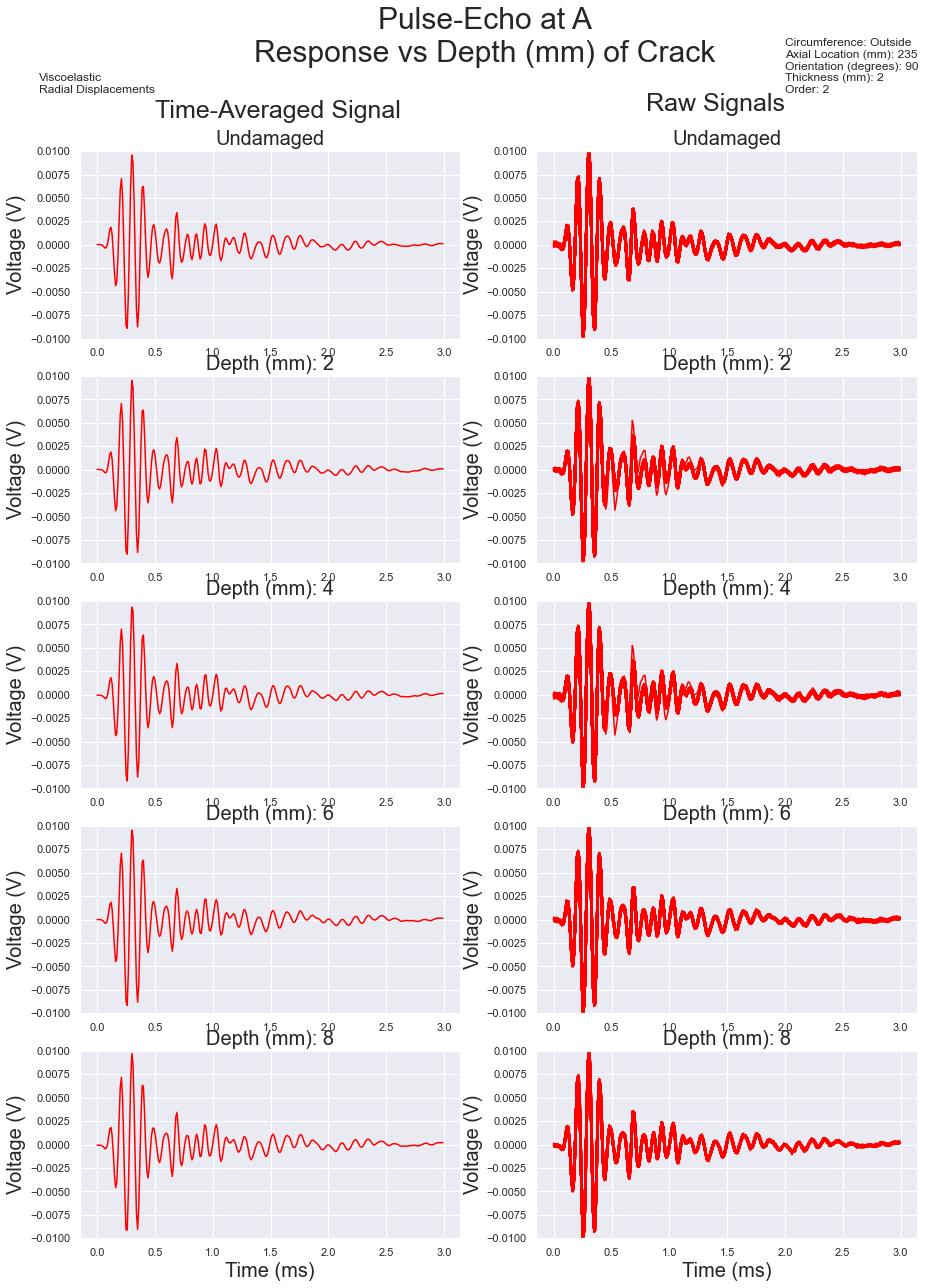

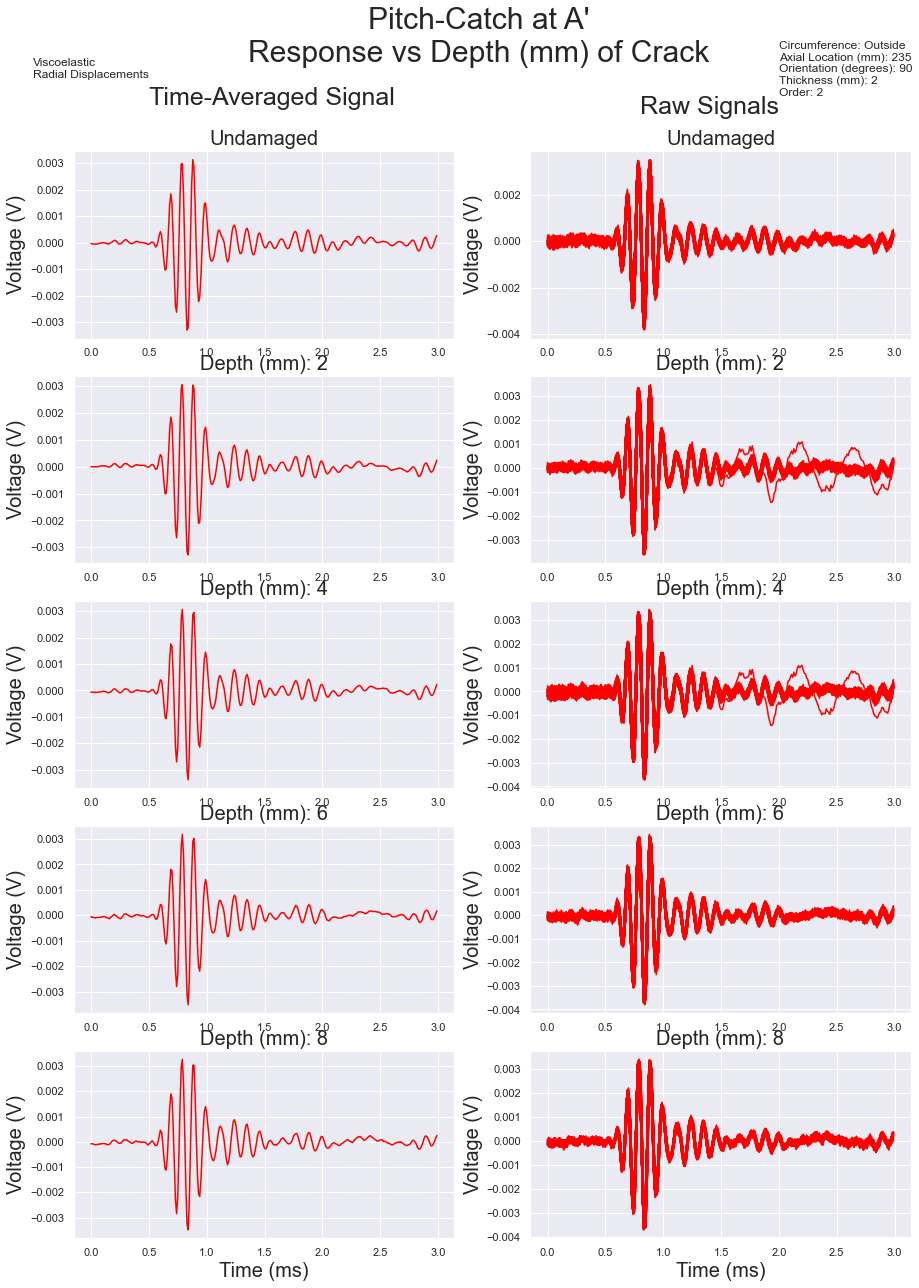

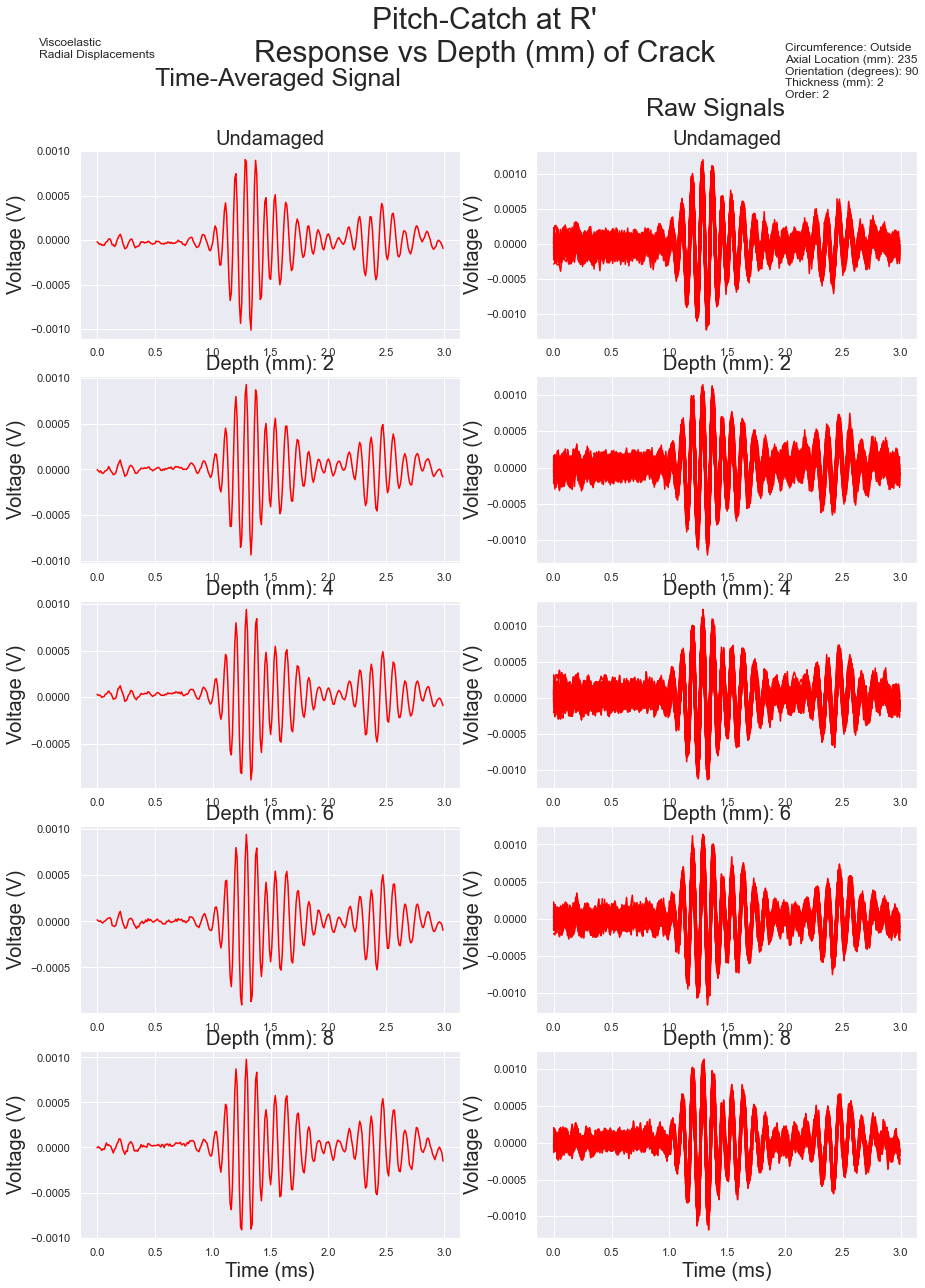

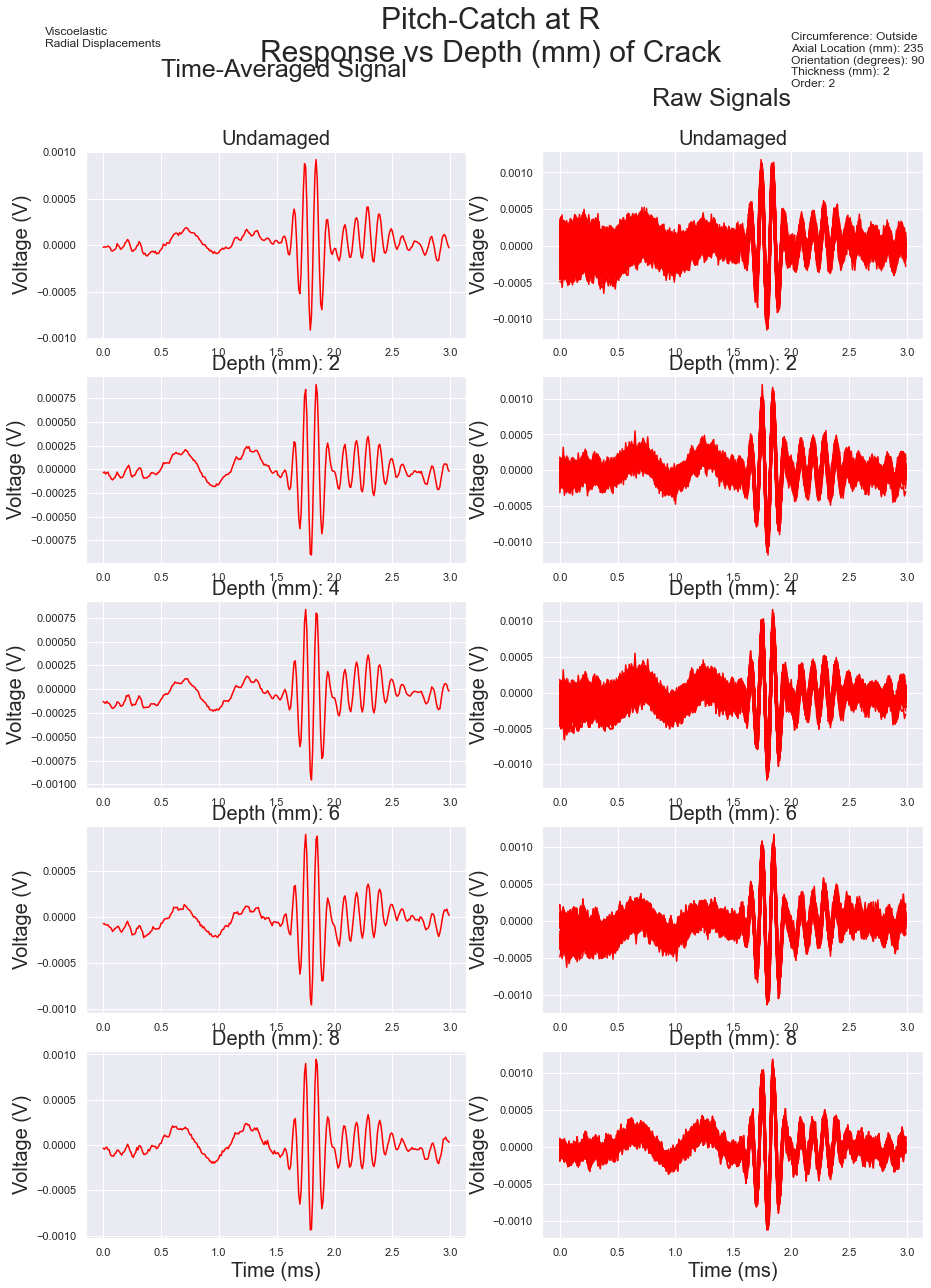

In [587]:
for Array in signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, 2, figsize = (15,20))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';
        
        while j < no_axes:
            axis = axes[j];

            is_state = averaged_signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = averaged_signals[Array]['Transducer','Axis'] == 4.0;
            signal   = averaged_signals[Array][is_state & is_axis];

            signal_time = signal['Time Domain (ms)'];
            
            if Configuration == 'Pulse-Echo':
                ax[i][0].set_ylim([-0.01, 0.01])
            
            if np.nan in signal_time:
                continue

            max_value = signal_time.to_numpy().max()
            
            ax[i][0].plot(time.transpose(),signal_time.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][0].set_ylabel('Voltage (V)', fontsize = 20)
            ax[i][0].grid(visible = True, which = 'major')

            j = j + 1;
            
        j = 0

        while j < no_axes:
            axis = axes[j];

            is_state = signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = signals[Array]['Transducer','Axis'] == 4.0;
            signal   = signals[Array][is_state & is_axis];

            signal_time = signal['Time Domain (ms)'];
            
            if Configuration == 'Pulse-Echo':
                ax[i][1].set_ylim([-0.01, 0.01])
            
            if np.nan in signal_time:
                continue

            max_value = signal_time.to_numpy().max()
            
            ax[i][1].plot(time.transpose(),signal_time.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][1].set_ylabel('Voltage (V)', fontsize = 20)

            j = j + 1;

        if i == 0:
            subtitle = 'Undamaged'
        else:
            subtitle = variable + ': ' + str(states[i])
        ax[i][0].set_title(subtitle, fontsize = 20)
        ax[i][1].set_title(subtitle, fontsize = 20)
            
        i = i + 1;

    ax[-1][0].set_xlabel('Time (ms)', fontsize = 20)
    ax[-1][1].set_xlabel('Time (ms)', fontsize = 20)
    
    if Configuration == 'Pulse-Echo':
        textyloc = 0.015;
    else:
        textyloc = max_value*1.7;

    ax[0][0].text(-0.5, textyloc, parameters, fontsize=12)
    ax[0][-1].text(2.0, textyloc, crack_props, fontsize=12)
    
    ax[0][0].text(0.5, 0.9*textyloc, 'Time-Averaged Signal', fontsize = 25)
    ax[0][1].text(0.8, 0.95*textyloc, 'Raw Signals', fontsize = 25)

    fig.suptitle(Configuration + ' at '+ Array +'\nResponse vs ' + variable + ' of Crack',fontsize = 30)

    fig.savefig(Array + ' ' + savename,dpi = 250)
    

In [588]:
savename = Pipe_physical + ' Noisy Amplitude Spectrum '
savename += '.png'
savename

'Pipe 4 Noisy Amplitude Spectrum .png'

In [589]:
signals['A']['Pipe','Designation']

3908    Pipe 4
3912    Pipe 4
3916    Pipe 4
3920    Pipe 4
3924    Pipe 4
         ...  
5784    Pipe 4
5788    Pipe 4
5792    Pipe 4
5796    Pipe 4
5800    Pipe 4
Name: (Pipe, Designation), Length: 508, dtype: object

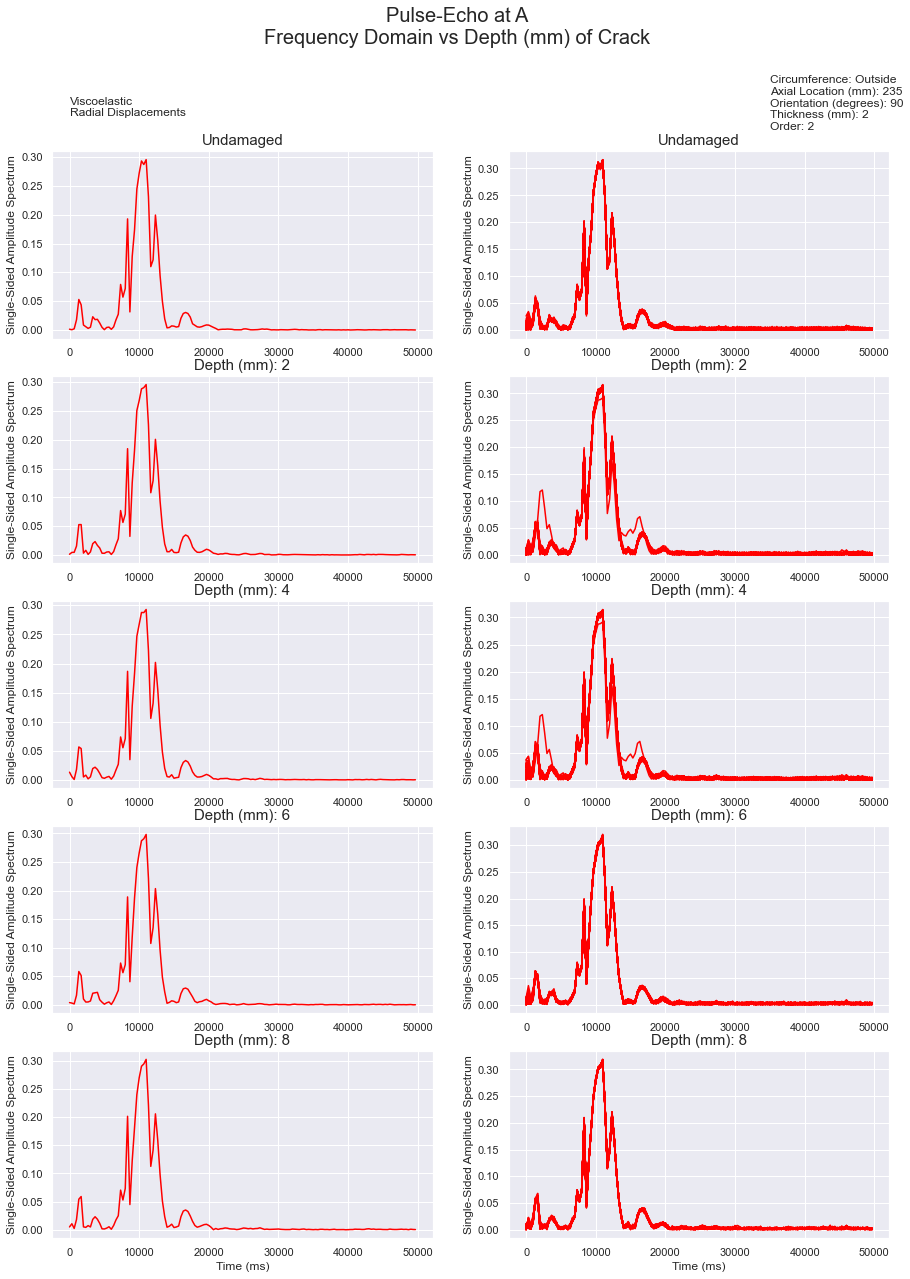

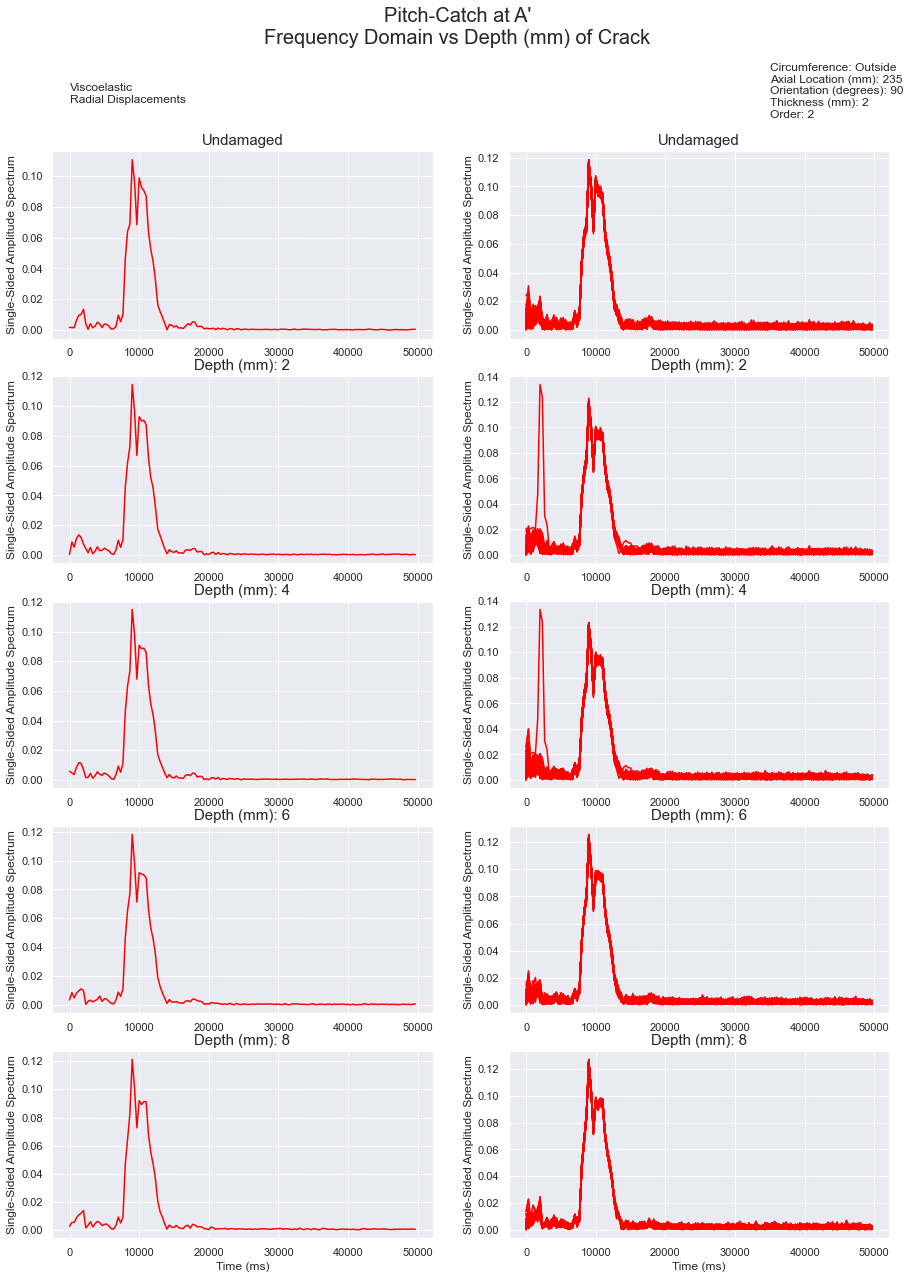

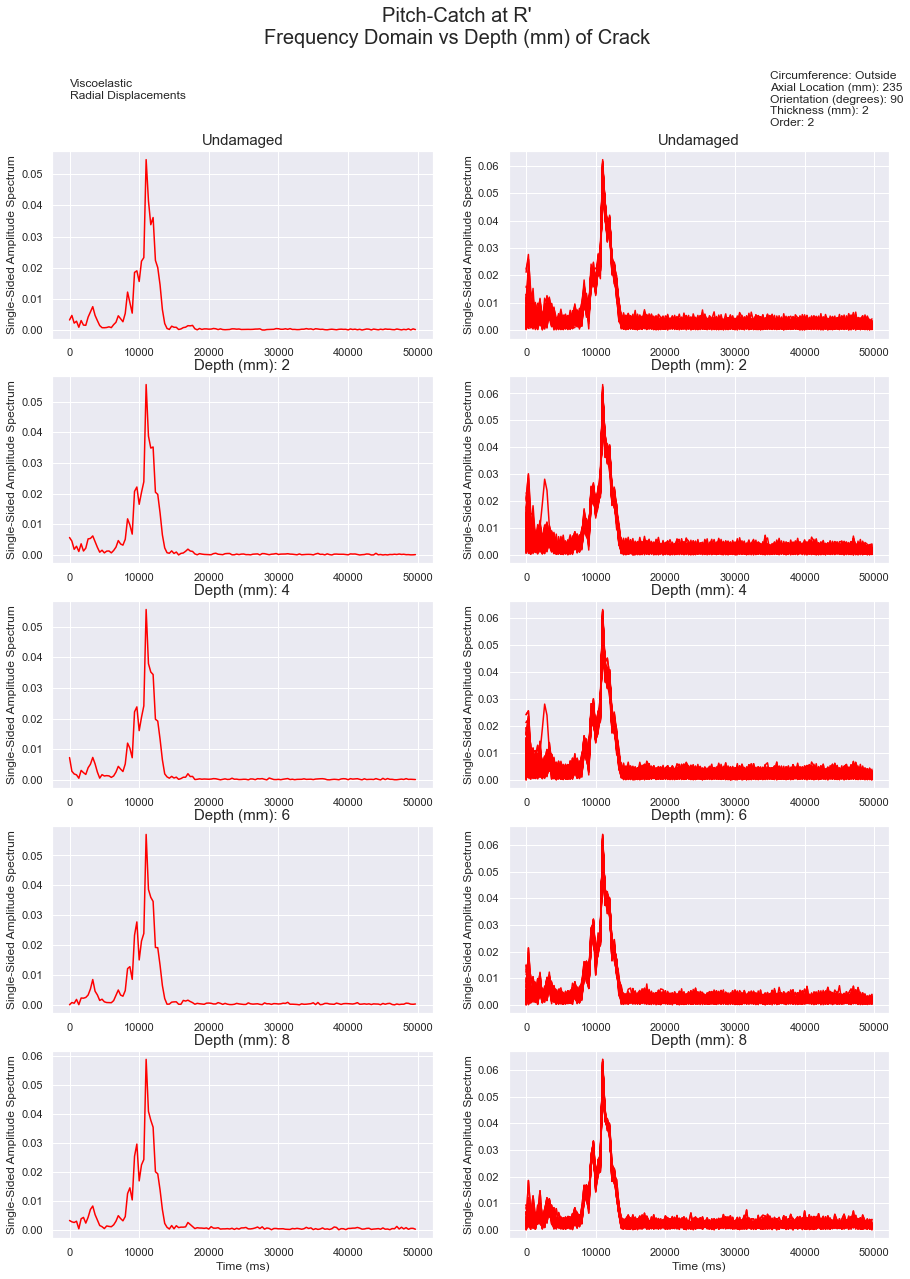

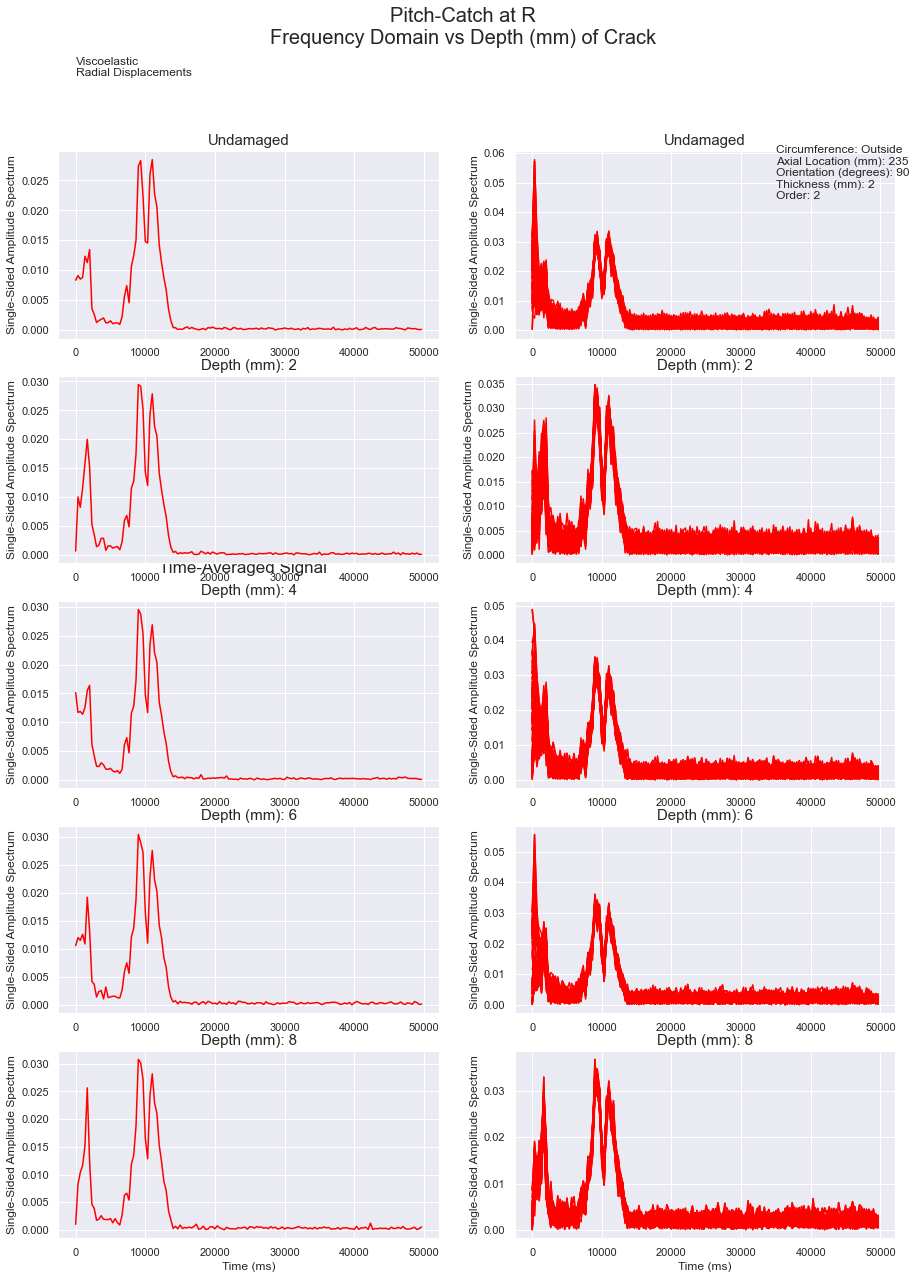

In [590]:
for Array in signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, 2, figsize = (15,20))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';
        
        while j < no_axes:
            axis = axes[j];

            is_state = averaged_signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = averaged_signals[Array]['Transducer','Axis'] == 4;
            signal   = averaged_signals[Array][is_state & is_axis];

            signal_freq = signal['Frequency Domain (Hz)'];
            
            if np.nan in signal_freq:
                continue

            max_value = signal_freq.to_numpy().max()
            
            ax[i][0].plot(signal_freq.columns,signal_freq.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][0].set_ylabel('Single-Sided Amplitude Spectrum', fontsize = 12)

            j = j + 1;
            
        j = 0

        while j < no_axes:
            axis = axes[j];

            is_state = signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = signals[Array]['Transducer','Axis'] == 4;
            signal   = signals[Array][is_state & is_axis];

            signal_freq = signal['Frequency Domain (Hz)'];
            
            if np.nan in signal_freq:
                continue

            max_value = signal_freq.to_numpy().max()
            
            ax[i][1].plot(signal_freq.columns,signal_freq.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][1].set_ylabel('Single-Sided Amplitude Spectrum', fontsize = 12)

            j = j + 1;

        if i == 0:
            subtitle = 'Undamaged'
        else:
            subtitle = variable + ': ' + str(states[i])
        ax[i][0].set_title(subtitle, fontsize = 15)
        ax[i][1].set_title(subtitle, fontsize = 15)
            
        i = i + 1;

    ax[-1][0].set_xlabel('Time (ms)', fontsize = 12)
    ax[-1][1].set_xlabel('Time (ms)', fontsize = 12)
    
    textyloc = max_value*1.1;

    ax[0][0].text(0, textyloc, parameters, fontsize=12)
    ax[0][-1].text(35000, textyloc, crack_props, fontsize=12)
    
    ax[0][0].text(12000, -1*textyloc, 'Time-Averaged Signal', fontsize = 17)
    ax[0][1].text(17000, -1*textyloc, 'Raw Signals', fontsize = 17)

    fig.suptitle(Configuration + ' at '+ Array +'\nFrequency Domain vs ' + variable + ' of Crack',fontsize = 20)

    fig.savefig(Array + ' ' + savename,dpi = 250)

### DWT Spectrogram

The discrete wavelet transform is an operation by which a mother wavelet (Daubacheis 1 in this case) is dilated and shifted across the domain of the signal in order to reconstruct it in a number of different frequencies. 

In [591]:
coeffs = pywt.wavedec(signal_time, 'db1', mode = 'sym', level = 5); # DWT
cA5, cD5, cD4, cD3, cD2, cD1 = coeffs

In [592]:
no_coeffs = 6;

In [593]:
savename = Pipe_physical + ' DWT ' + Elasticity + ' ' + disps 
savename += '.png'
savename

'Pipe 4 DWT Viscoelastic Radial Displacements.png'

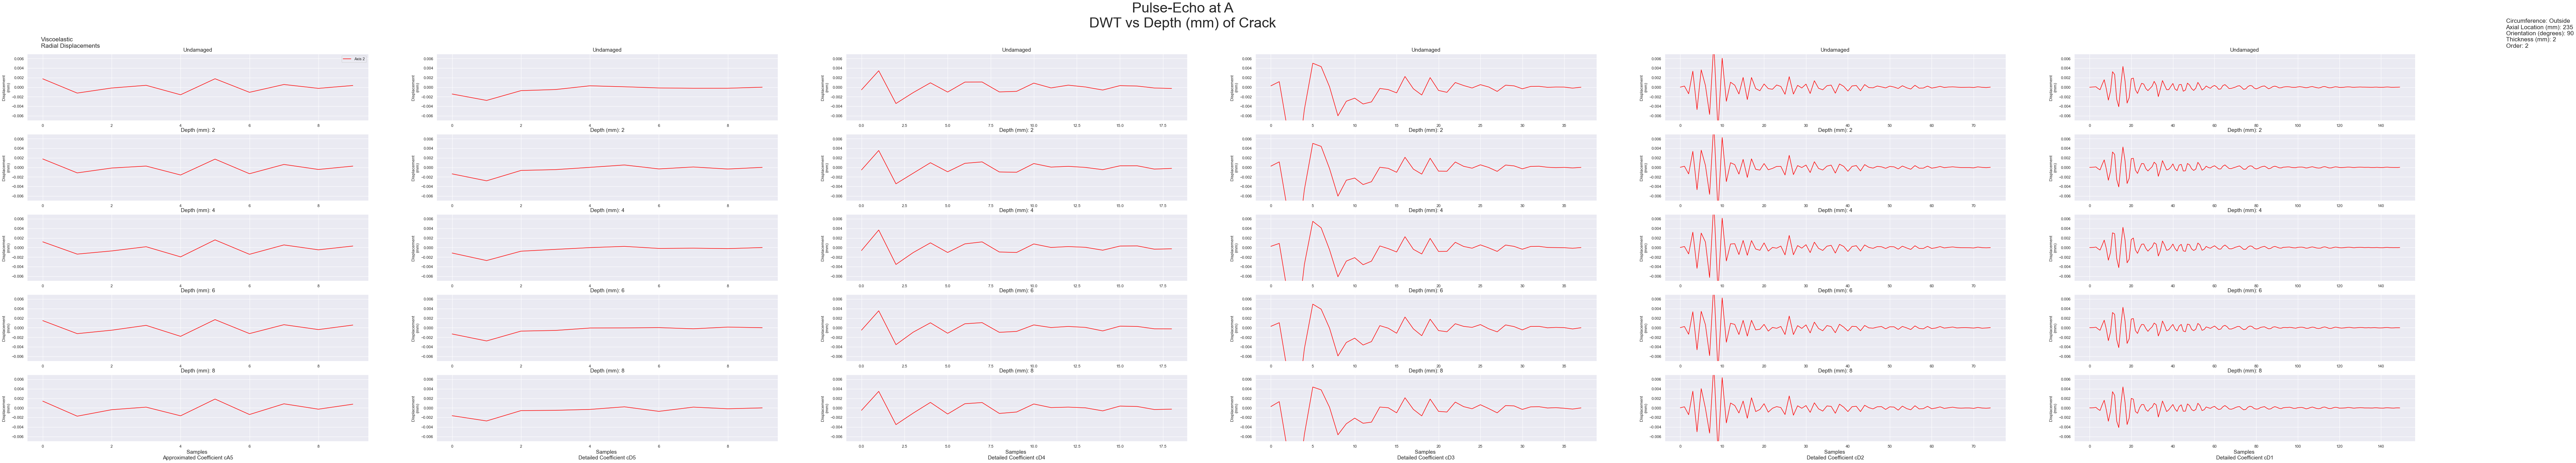

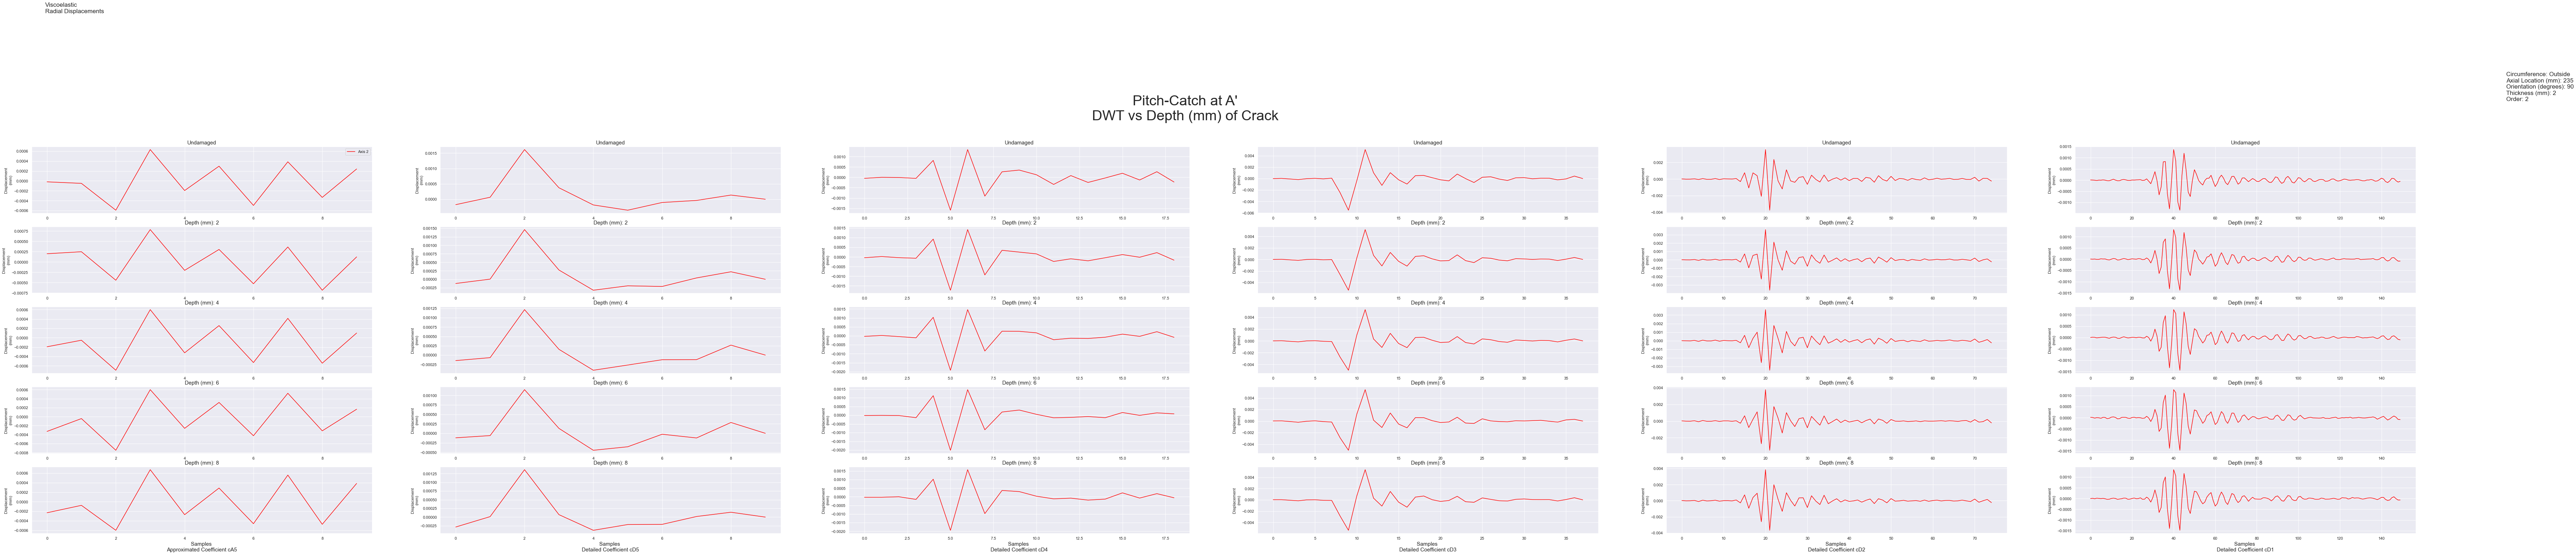

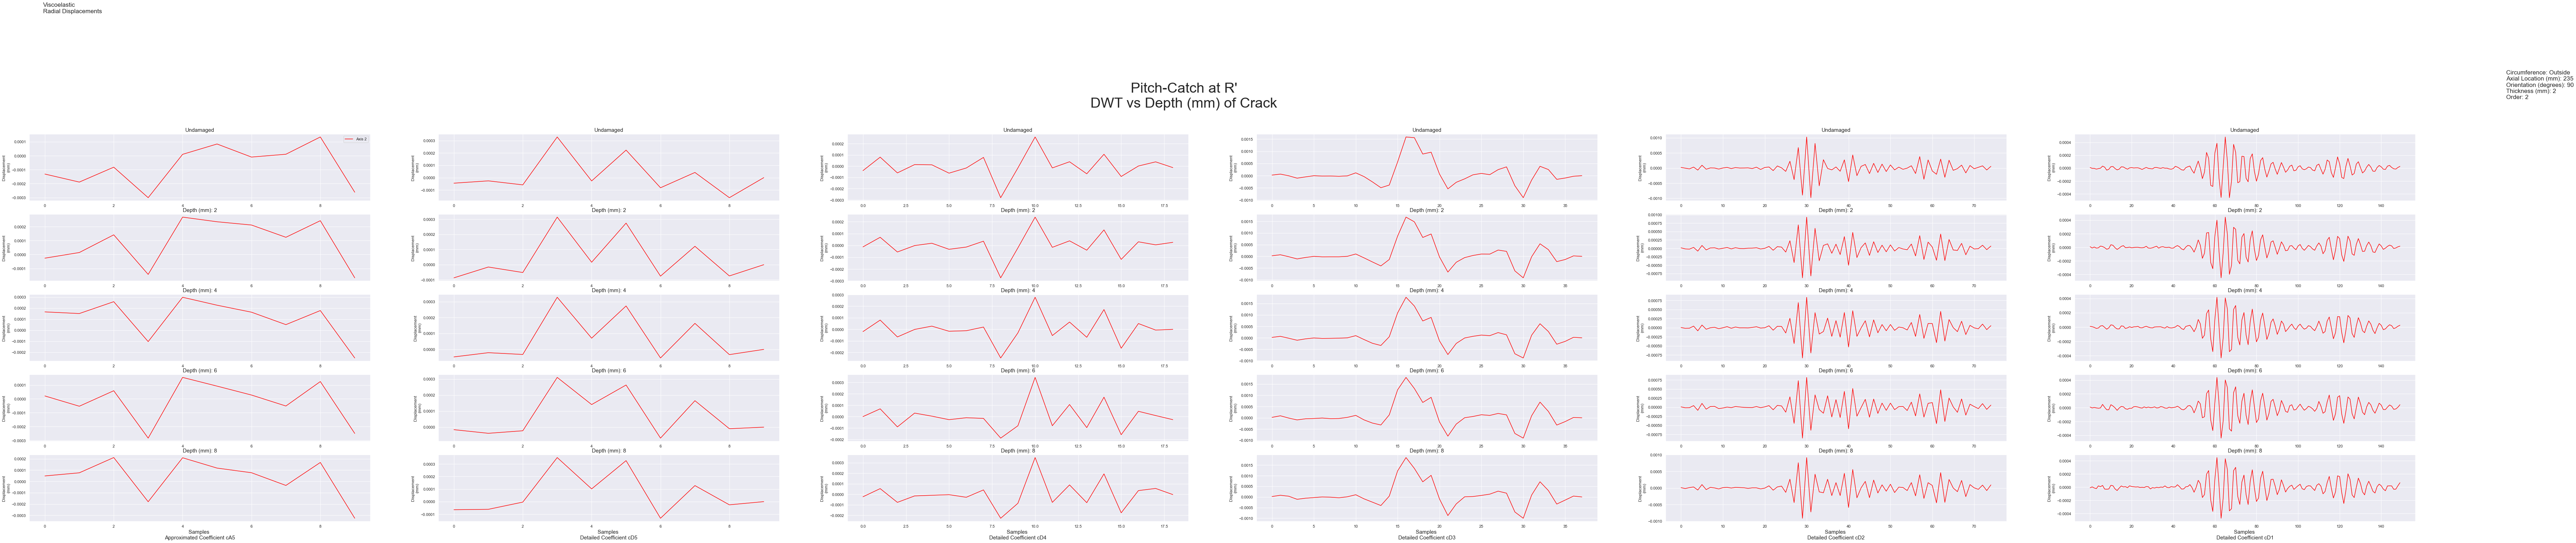

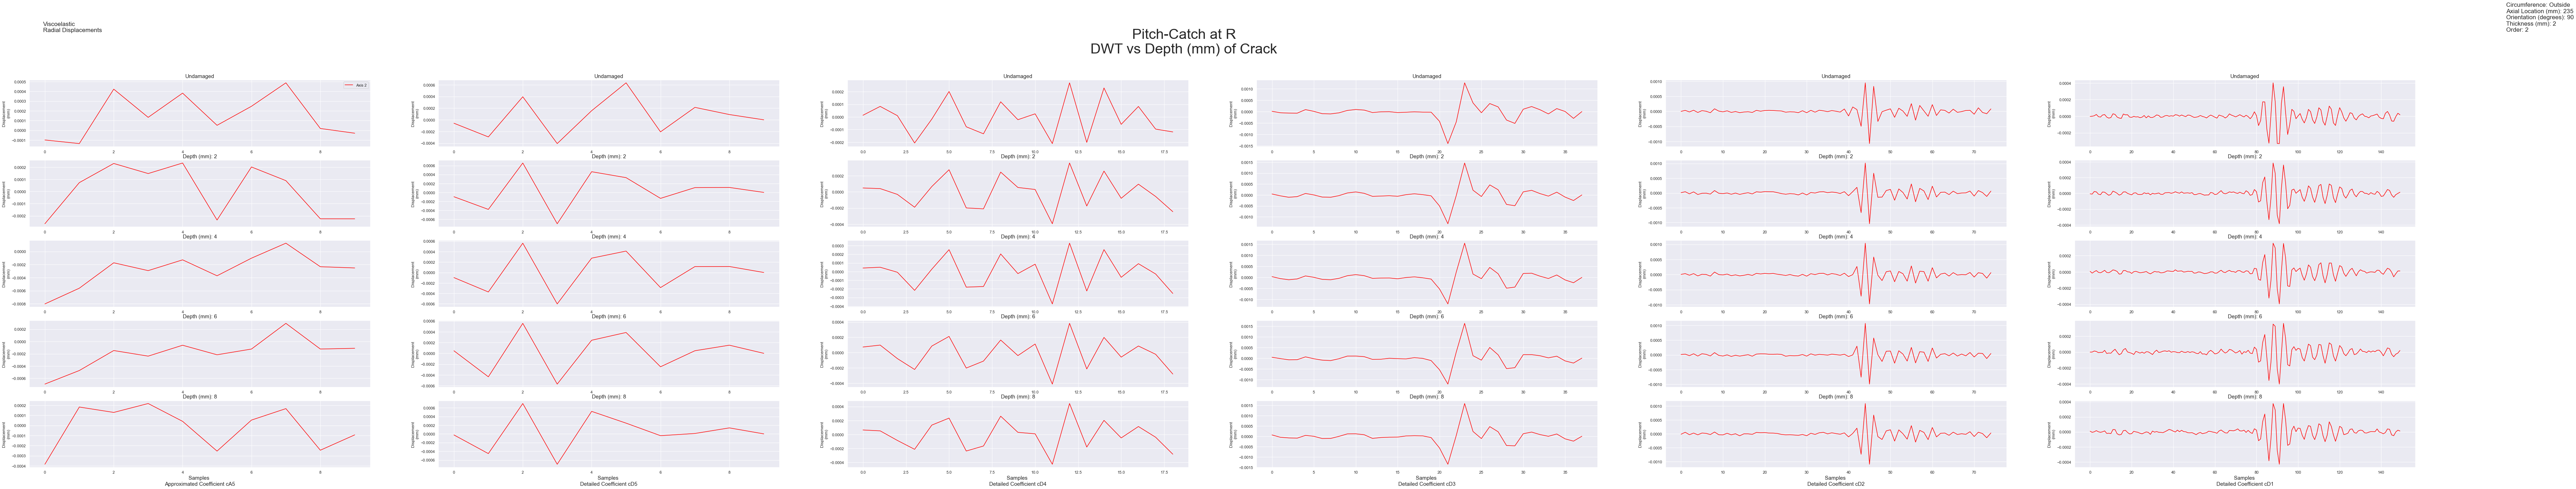

In [594]:
for Array in averaged_signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, no_coeffs, figsize = (120,20))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';

        while j < no_axes:
            axis = axes[j];

            is_state = averaged_signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = averaged_signals[Array]['Transducer','Axis'] == 4;
            signal   = averaged_signals[Array][is_state & is_axis];

            signal_time = signal['Time Domain (ms)'];
            
            if np.nan in signal_time:
                continue

            max_value = signal_time.to_numpy().max()
            
            coeffs = pywt.wavedec(signal_time, 'db1', mode = 'sym', level = 5); # DWT
            cA5, cD5, cD4, cD3, cD2, cD1 = coeffs
            
            k = 0
            for coeff in coeffs:
                
                if Configuration == 'Pulse-Echo':
                    ax[i][k].set_ylim([-0.007, 0.007])
                
                samples = np.arange(0,len(coeff.transpose()))
                ax[i][k].plot(samples,coeff.transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
                ax[i][k].set_ylabel('Displacement \n(mm)', fontsize = 12)
                                
                if i == 0:
                    subtitle = 'Undamaged'
                else:
                    subtitle = variable + ': ' + str(states[i])
                ax[i][k].set_title(subtitle, fontsize = 15)

                k = k + 1;

            j = j + 1;
            
        i = i + 1;


    ax[0][0].legend(loc = 'best', ncol = 1)
    
    if Configuration == 'Pulse-Echo':
        textyloc = 0.007;
    else:
        textyloc = max_value;

    ax[-1][0].set_xlabel('Samples \nApproximated Coefficient cA5', fontsize = 15)
    ax[-1][1].set_xlabel('Samples \nDetailed Coefficient cD5', fontsize = 15)
    ax[-1][2].set_xlabel('Samples \nDetailed Coefficient cD4', fontsize = 15)
    ax[-1][3].set_xlabel('Samples \nDetailed Coefficient cD3', fontsize = 15)
    ax[-1][4].set_xlabel('Samples \nDetailed Coefficient cD2', fontsize = 15)
    ax[-1][5].set_xlabel('Samples \nDetailed Coefficient cD1', fontsize = 15)
        
    ax[0][0].text(-0.05, textyloc, parameters, fontsize=17)
    ax[0][-1].text(200, textyloc, crack_props, fontsize=17)

    fig.suptitle(Configuration + ' at '+ Array +'\nDWT vs ' + variable + ' of Crack',fontsize = 40)

    # fig.savefig(Array + ' ' + savename,dpi = 250)

## Principal Component Analysis

Objective: Classify the noisy damage data via the amplitudes in the frequency domains. 

Begin by isolating only the frequencies which best describe teh signal. For our purposes, this will be the frequencies between 7,000 Hz and 13,000 Hz.

In [595]:
imp_freqs = []
for freq in list(P1['Frequency Domain (Hz)'].columns):
    if (freq >= 7000):
        if (freq <= 12000):
            imp_freqs.append(freq)

Define the color markers for each damaged state

In [596]:
colors_index = [0] * 10 
colors_index[0:len(states)] = states
colors = {colors_index[0]:'black', 
          colors_index[1]:'blue', 
          colors_index[2]:'green', 
          colors_index[3]:'purple', 
          colors_index[4]:'red', 
          colors_index[5]:'magenta', 
          colors_index[6]:'cyan', 
          colors_index[7]:'black'}

colors

{0: 'black', 2: 'blue', 4: 'green', 6: 'purple', 8: 'red'}

Plot all frequency domains on one graph per transducer array. Color-code them by damaged state. We're examining Axis 2, the axis with the crack.

Run a preliminary PCA analysis on the frequency domains to transform the data to a 2-PC space. Obtain the amount of variance from the original dataset explained by the principal components.

Finally, plot the transducer frequency response on the transformed plane. Because the variance is explained concisely with just two principal components, it should be much easier to cluster the damaged states on the transformed plane. 

In [597]:
max(max_signals['R']['Frequency Domain (Hz)'].max())

0.05787368145960243

In [598]:
savename1 = Pipe_physical + ' Damaged State as a Function of Frequency Variables '
savename1 += '.png'
savename1

savename2 = Pipe_physical + ' Preliminary PCA '
savename2 += '.png'
savename2

savename3 = Pipe_physical + ' Damaged State as a Function of Principal Components '
savename3 += '.png'
savename3

'Pipe 4 Damaged State as a Function of Principal Components .png'

In [599]:
colors.keys()

dict_keys([0, 2, 4, 6, 8])

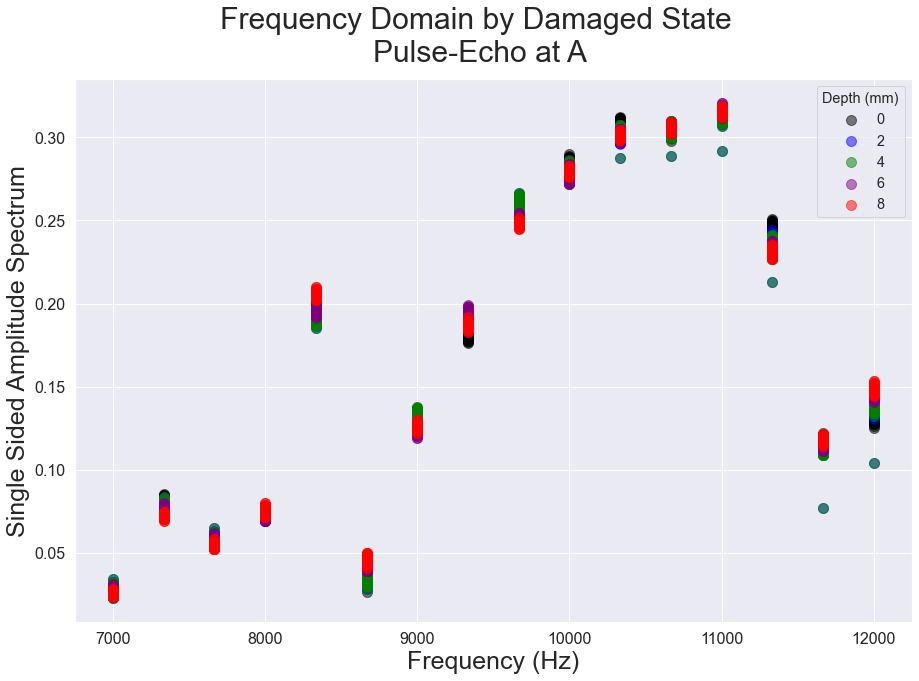

original shape:    (508, 16)
transformed shape: (508, 2)
Variance explained by each principal component 
PC1: 0.46300450257704395 
PC2: 0.2094574464152427


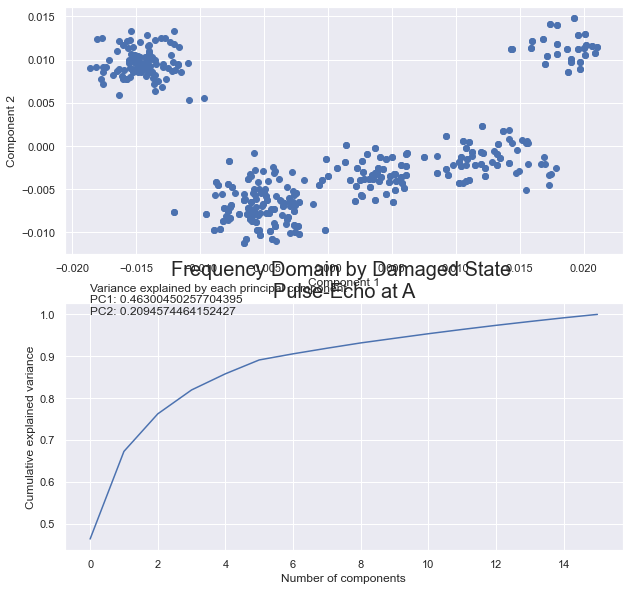

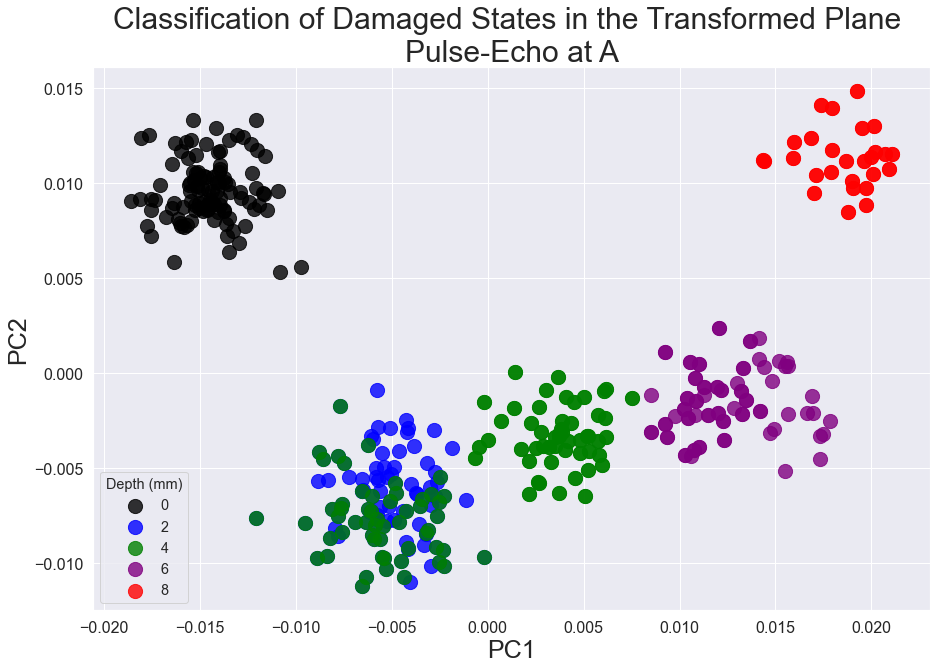

Pulse-Echo at A
Number of Principal Components = 6
Accuracy of Classification = 94.5%
Accuracy List = 0.905511811023622, 0.9212598425196851, 0.9212598425196851, 0.9291338582677166, 0.937007874015748, 0.9448818897637795, 0.937007874015748, 0.9291338582677166, 0.9291338582677166, 0.9291338582677166, 0.9291338582677166, 0.9212598425196851


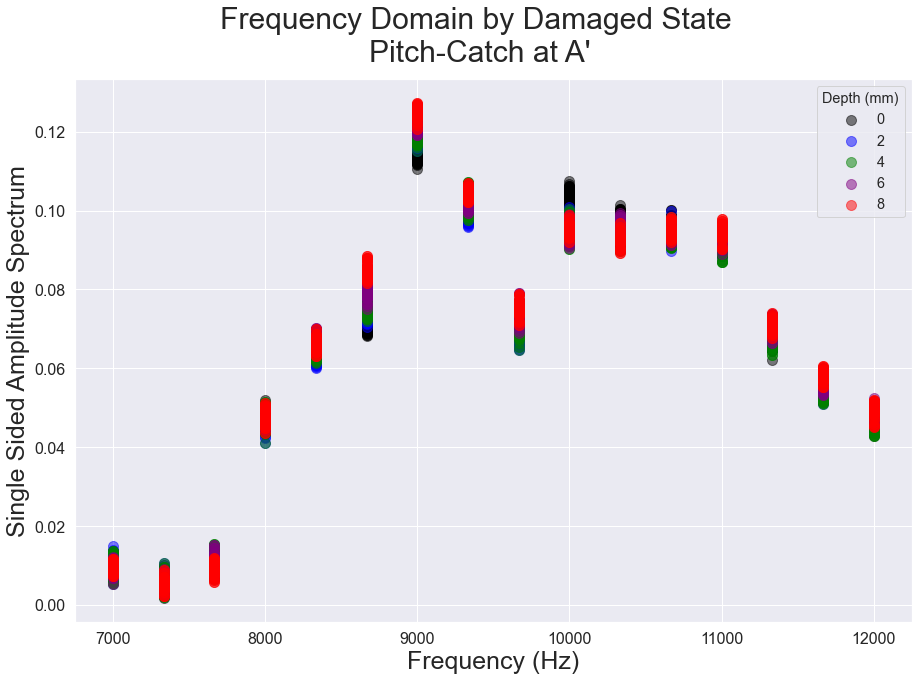

original shape:    (508, 16)
transformed shape: (508, 2)
Variance explained by each principal component 
PC1: 0.43755780363112373 
PC2: 0.11523168493552076


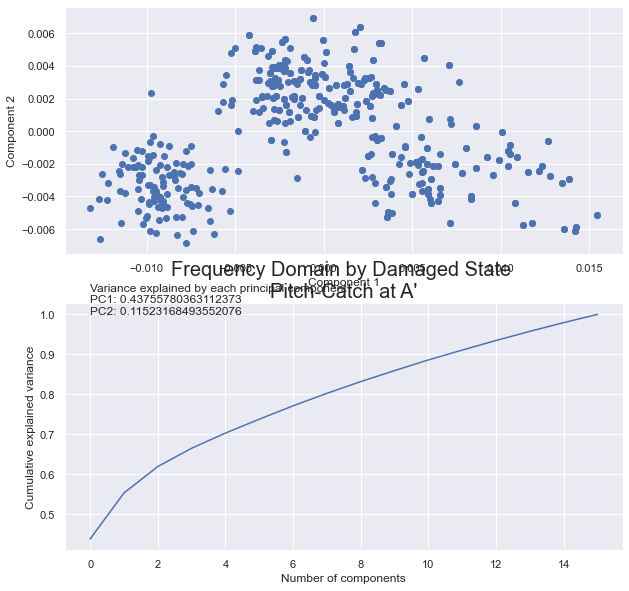

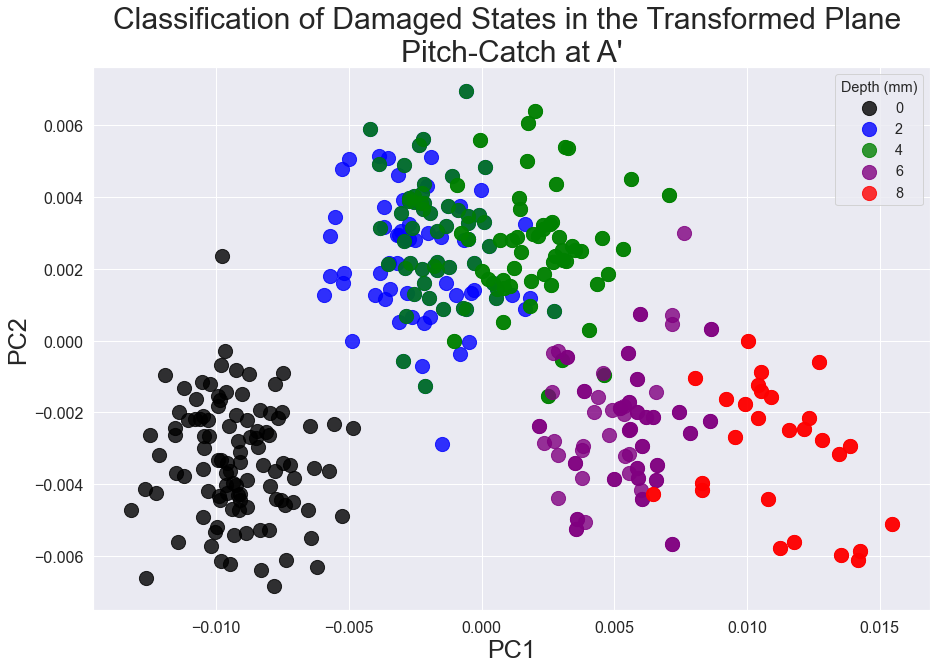

Pitch-Catch at A'
Number of Principal Components = 11
Accuracy of Classification = 92.9%
Accuracy List = 0.8188976377952756, 0.8267716535433071, 0.8976377952755905, 0.8976377952755905, 0.905511811023622, 0.8818897637795275, 0.8976377952755905, 0.905511811023622, 0.8976377952755905, 0.889763779527559, 0.9291338582677166, 0.905511811023622


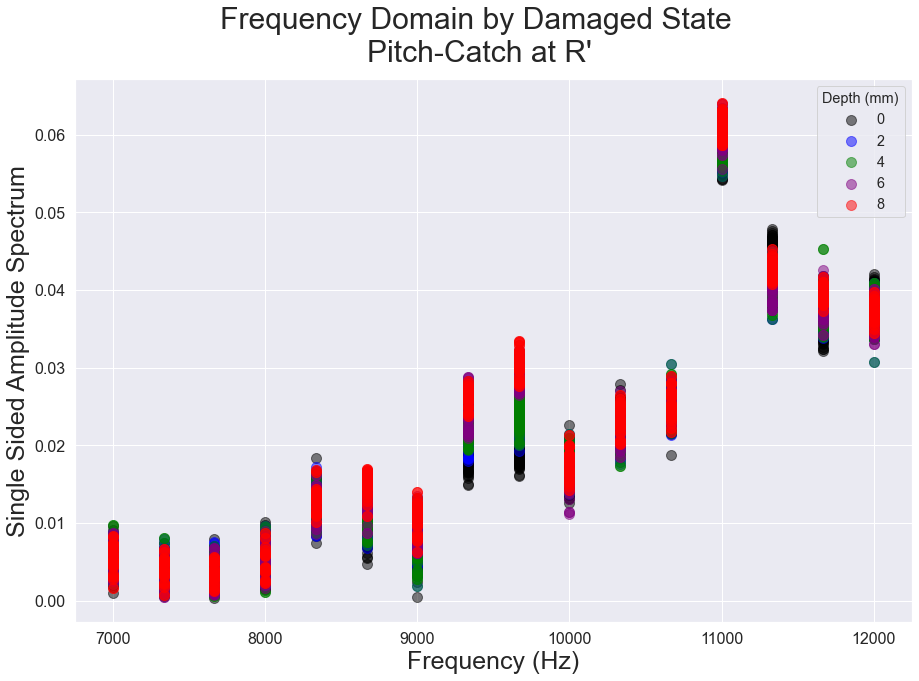

original shape:    (508, 16)
transformed shape: (508, 2)
Variance explained by each principal component 
PC1: 0.39334389006992604 
PC2: 0.07799050145958727


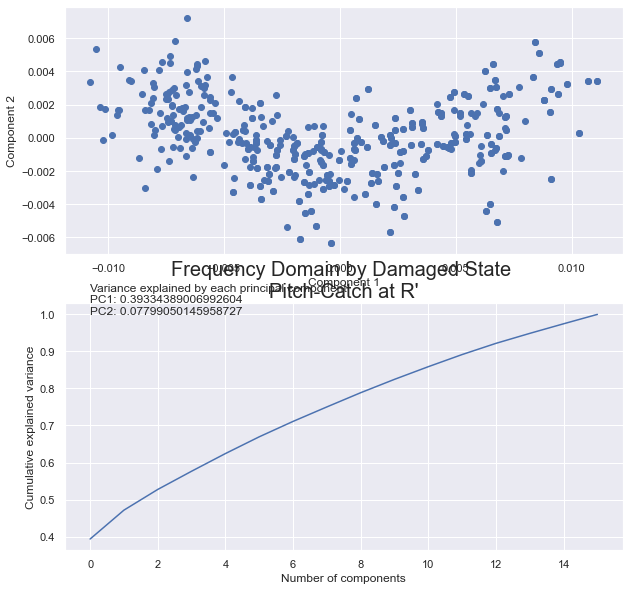

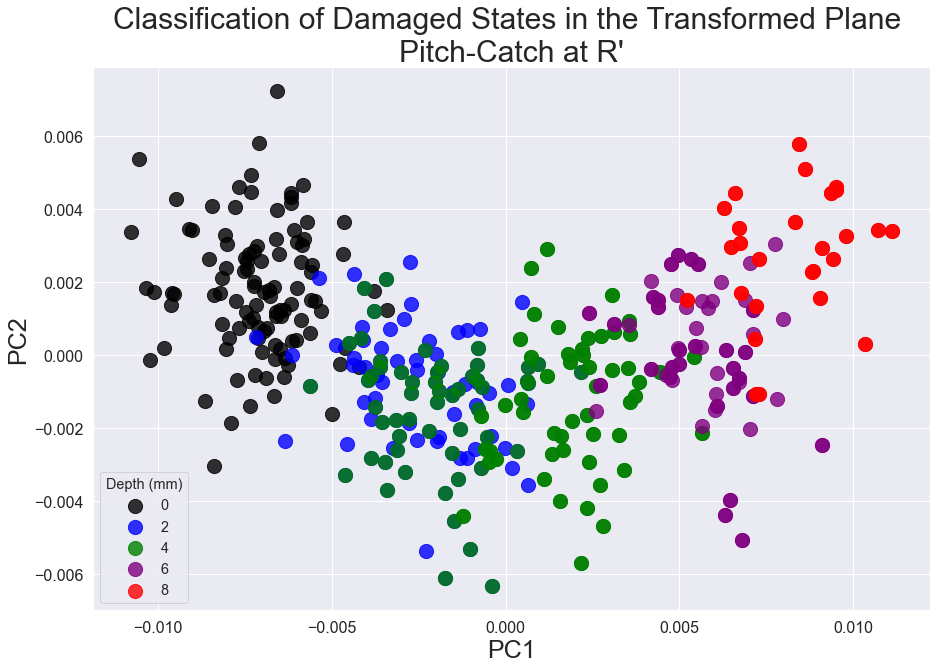

Pitch-Catch at R'
Number of Principal Components = 1
Accuracy of Classification = 85.8%
Accuracy List = 0.8582677165354331, 0.84251968503937, 0.7952755905511811, 0.7795275590551181, 0.7952755905511811, 0.7559055118110236, 0.7322834645669292, 0.7637795275590551, 0.7795275590551181, 0.7716535433070866, 0.7716535433070866, 0.8188976377952756


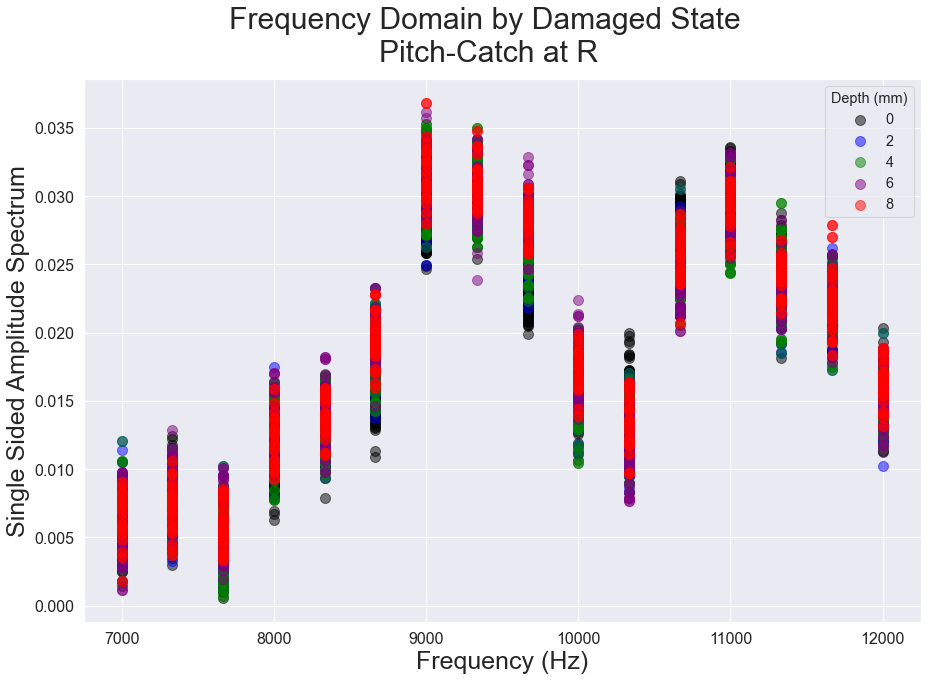

original shape:    (508, 16)
transformed shape: (508, 2)
Variance explained by each principal component 
PC1: 0.2101951575321851 
PC2: 0.09138658829815408


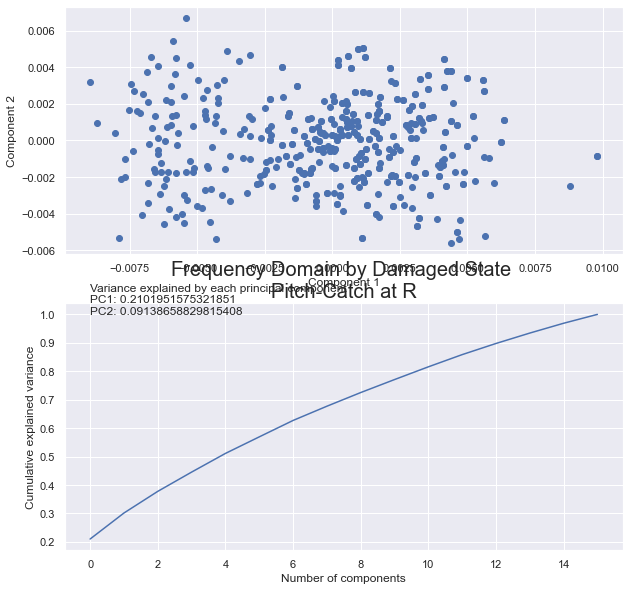

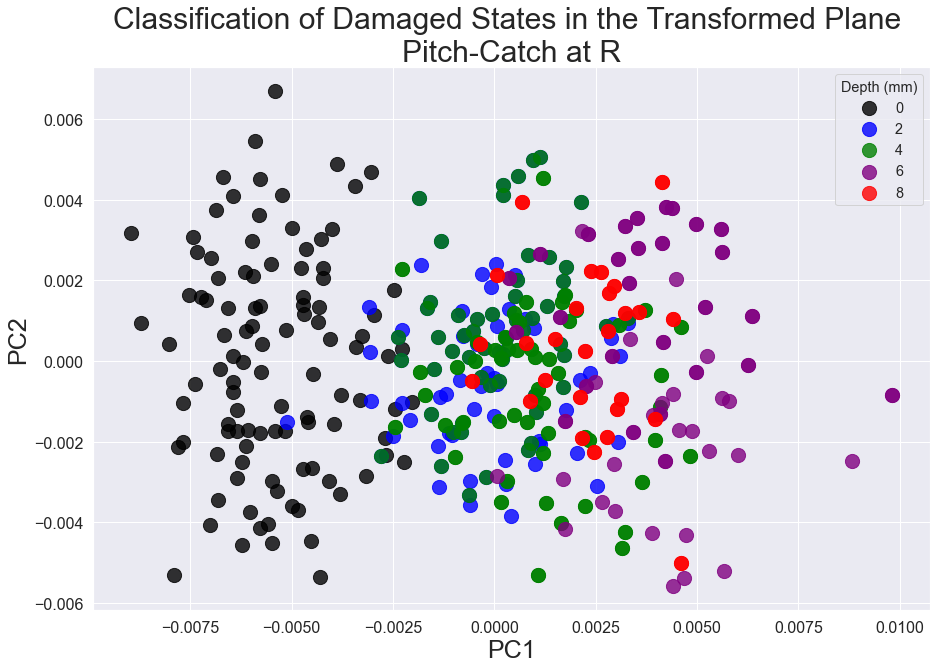

C:\Users\Wei Sun\Documents\Python\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Wei Sun\Documents\Python\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Wei Sun\Documents\Python\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pitch-Catch at R
Number of Principal Components = 12
Accuracy of Classification = 78.7%
Accuracy List = 0.6220472440944882, 0.6456692913385826, 0.7086614173228346, 0.6614173228346457, 0.6535433070866141, 0.6535433070866141, 0.6692913385826772, 0.6771653543307087, 0.6692913385826772, 0.7244094488188977, 0.7480314960629921, 0.7874015748031497


In [600]:
all_pcs = {}
pc_data = {}

for Array in signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'

    is_axis        = signals[Array]['Transducer','Axis'] == 4;
    interest_freqs = signals[Array][is_axis]['Frequency Domain (Hz)'][imp_freqs]
    interest_freqs[variable] = signals[Array][is_axis]['Crack Properties', variable]

    states = interest_freqs[variable].unique()
    
    # Plot the frequency domains
    fig, ax = plt.subplots(figsize = (15,10))
    
    max_value = max(max_signals[Array]['Frequency Domain (Hz)'].max())

    for freq in imp_freqs:
        for state in states:
            c = colors[state]
            x1 = np.ones(len(interest_freqs[interest_freqs[variable] == state][freq].index));
            x1 = x1*freq;
            plt.scatter(x = x1, y = interest_freqs[interest_freqs[variable] == state][freq], alpha = 0.5, color = c, s = 100)
            
    # ax.text(imp_freqs[0], max_value*1.2, parameters, fontsize=17)
    # ax.text(imp_freqs[0]+(imp_freqs[-1]-imp_freqs[0])*5/6, max_value*1.2, crack_props, fontsize=17)
    
    plt.legend(states, title = variable, loc = 'best', fancybox = True, fontsize = 'large', title_fontsize = 'large');
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)    
    plt.ylabel('Single Sided Amplitude Spectrum', fontsize = 25)
    plt.xlabel('Frequency (Hz)', fontsize = 25)    
    fig.suptitle('Frequency Domain by Damaged State \n' + Configuration + ' at ' + Array, fontsize = 30)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
    fig.savefig(Array + ' ' + savename1,dpi = 250)
    
    # Plot the preliminary results and cumulative explained variance vs number of PCs
    freq_pca, comps, transformed_freq = prePCA(interest_freqs.drop(variable, axis = 1))
    plt.title('Frequency Domain by Damaged State \n' + Configuration + ' at ' + Array, fontsize = 20)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
    reduced_dataset = pd.DataFrame(transformed_freq)
    reduced_dataset.columns = ['Principal Component 1', 'Principal Component 2']
    interest_freqs.reset_index(drop=True, inplace=True)
    reduced_dataset.reset_index(drop=True, inplace=True)
    reduced_dataset[variable] = interest_freqs[variable]
    reduced_dataset.set_index(variable)
    
    pc_data[Array] = reduced_dataset
    
    pcs         = pd.DataFrame(comps)
    pcs.columns = imp_freqs
    pcs.index   = ['PC1','PC2']
    pcs
    
    all_pcs[Array] = pcs
    
    # print('Principal Components: '+comps)
    
    fig.savefig(Array + ' ' + savename2,dpi = 250)
    
    # Plot the damage data on the transformed plane and color code them by damaged state
    fig, ax = plt.subplots(figsize = (15,10))

    for state in states:
        x = reduced_dataset[reduced_dataset[variable] == state]['Principal Component 1'];
        y = reduced_dataset[reduced_dataset[variable] == state]['Principal Component 2'];
        c = colors[state];
        plt.scatter(x = x, y = y, alpha = 0.8, color = c, s= 200); 

    plt.legend(colors.keys(), title = variable, loc = 'best', fancybox = True, fontsize = 'large', title_fontsize = 'large');
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)    
    plt.ylabel('PC2', fontsize = 25)
    plt.xlabel('PC1', fontsize = 25)    
    plt.title('Classification of Damaged States in the Transformed Plane \n' + Configuration + ' at ' + Array , fontsize = 30)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
    fig.savefig(Array + ' ' + savename3,dpi = 250)
    
    # Perform an SVM to determine the ideal number of PCs for best accuracy
    scaler = StandardScaler()
    x = scaler.fit_transform(interest_freqs)
    y = interest_freqs[variable]

    Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, random_state=42)

    classification_list = []
    accuracy_list = []
    transformed_data_list = []
    models = {}

    for i in range(1,13):
        classification, accuracy, transformed_data, model = pca_svm(n_components = i)
        classification_list.append(classification)
        accuracy_list.append(accuracy)
        transformed_data_list.append(transformed_data)
        models[i] = model
        
    max_acc = max(accuracy_list)
    num_PCs = accuracy_list.index(max_acc)+1

    max_acc = float("{:.3f}".format(max_acc))
    print(color.BOLD + Configuration + ' at ' + Array + 
          "\nNumber of Principal Components = " + str(num_PCs) +
          '\n' + "Accuracy of Classification = " + str(max_acc*100) + "%"
          '\n' "Accuracy List = " + str(accuracy_list)[1:-1] + color.END)

In [601]:
pickle.dump(all_pcs,open('Experimental PCs', 'ab'))
pickle.dump(pc_data,open('Experimental PC Data', 'ab'))

An preliminary SVM script was run to determine the optimal number of PCs to maximize classification accuracy. However for the sake of simplicity, all ensuing operations are performed on the plane of two principal components for each array.

Examine the principal components as linear combinations of the frequency value variables

In [602]:
all_pcs['A\'']

7000.000000   7333.333333   7666.666667   8000.000000   8333.333333   \
PC1     -0.047866      0.002062     -0.008389      0.032299      0.074202   
PC2      0.031255     -0.042160      0.113109     -0.062584     -0.311731   

     8666.666667   9000.000000   9333.333333   9666.666667   10000.000000  \
PC1      0.631823      0.492347      0.191971      0.224236     -0.432065   
PC2     -0.190667     -0.019854      0.013726     -0.451145     -0.587084   

     10333.333333  10666.666667  11000.000000  11333.333333  11666.666667  \
PC1     -0.188094     -0.044867      0.089919      0.136074      0.081111   
PC2     -0.345167     -0.117207     -0.216078     -0.098453     -0.293929   

     12000.000000  
PC1      0.071353  
PC2     -0.150226

In [603]:
for array in arrays:
    all_pcs[array].index.name = 'Frequency (Hz)'
    all_pcs[array] = all_pcs[array].transpose()
    all_pcs[array].to_excel('PCs at ' + array + '.xlsx', index=True)

In [604]:
pickle.dump(all_pcs,open('All Principal Components','ab'))

In [605]:
pickle.load(open('All Principal Components','rb'))
all_pcs['A']

Frequency (Hz)       PC1       PC2
7000.000000    -0.101527 -0.077399
7333.333333    -0.268720 -0.006458
7666.666667    -0.090192 -0.035873
8000.000000    -0.003806  0.086211
8333.333333     0.164069  0.650479
8666.666667     0.416924  0.184060
9000.000000    -0.212181  0.021309
9333.333333     0.291392 -0.422528
9666.666667    -0.275119 -0.436412
10000.000000   -0.186479  0.127153
10333.333333   -0.177086  0.163235
10666.666667    0.089423 -0.061442
11000.000000    0.102526  0.138623
11333.333333   -0.370658  0.160631
11666.666667   -0.019469  0.209500
12000.000000    0.529678 -0.152675

The coordinates on the 2 PCs plane and the damaged states are stored for each datapoint on each array. This will be used in the machine learning script.

In [606]:
for array in arrays:
    pc_data[array] = pc_data[array].set_index(variable)

In [607]:
# pc_data['A\''] = pc_data['A\''].set_index(variable)
pc_data['A\'']

Principal Component 1  Principal Component 2
Depth (mm)                                              
0                       -0.005564              -0.002308
0                       -0.007088              -0.004508
0                       -0.007484              -0.000897
0                       -0.009650              -0.000276
0                       -0.007741              -0.004414
...                           ...                    ...
8                        0.008035              -0.001052
8                        0.015468              -0.005116
8                        0.010530              -0.000868
8                        0.009218              -0.001612
8                        0.009562              -0.002671

[508 rows x 2 columns]

In [608]:
pc_data['A\''].groupby(pc_data['A\''].index).count()

Principal Component 1  Principal Component 2
Depth (mm)                                              
0                             105                    105
2                             108                    108
4                             159                    159
6                              82                     82
8                              54                     54

Confirm that the target vector for the PCs at each transducer array are all the same.

In [609]:
pc_data['A'].index.to_list() == pc_data['A\''].index.to_list()

True

In [610]:
pc_data['R\''].index.to_list() == pc_data['A\''].index.to_list()

True

In [611]:
pc_data['R'].index.to_list() == pc_data['R\''].index.to_list()

True

In [612]:
pickle.dump(pc_data,open('Experimental PCs','ab'))

Get 500 datapoints at least. If you still manage to obtain an accuracy of at least 80%, overfitting has been controlled better

## Machine Learning

We will be applying the support vector machine (SVM) method to increase the dimensionality of the PCA results, mathematically group all the datapoints between characteristic hyperplanes, verify the accuracy of the results, and save a model for later validation and use.

In [613]:
import sklearn.svm as svm

Begin by extracting samples from the generated dictionaries to form data arrays and target vectors.

Standardize the data and transform it to a dataset of z-scores

The support vector classifier (SVC) is the border between any two classes in the native dimension of the dataset. In the higher dimension, it is known as the hyperplane. 
A decision function shape of ovo means that the SVC selection method is one-vs-one. This means that one SVC exists between any pair of classes. The total number of SVCs in this case is n*(n-1)/2, where is is the number of classes.
Alternatively, there is a selection method known as ovr (one-vs-rest). This means that one SVC exist between any one class and all other classes. The total number of SVCs in this case is n.

In [614]:
Xtrain_by_array = {}
Xtest_by_array  = {}
# ytrain_by_array = {}
# ytest_by_array  = {} Not necessary because all pc_data dataframes have the same index column

for array in arrays:
    x = pc_data[array][pc_data[array].columns].values
    y = pc_data[array].index
    scaler = StandardScaler()
    X = scaler.fit_transform(x)
    
    clf = svm.SVC(decision_function_shape = 'ovo')
    clf.fit(X,y)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42)
    
    Xtrain_by_array[array] = Xtrain
    Xtest_by_array[array]  = Xtest
    # ytrain_by_array[array] = ytrain
    # ytest_by_array[array]  = ytest

Standardized train and test data:

In [615]:
Xtrain_by_array['A']

array([[-2.39516364e-01, -1.01448044e+00],
       [-1.45554241e+00,  1.58412953e+00],
       [ 4.16226626e-01, -7.48304220e-01],
       [-1.40779750e+00,  1.22405349e+00],
       [ 1.29276485e+00, -2.71534650e-01],
       [-2.73204412e-01, -8.06162881e-01],
       [ 6.85113426e-01, -1.78381339e-01],
       [-5.01744269e-01, -1.30997972e+00],
       [ 1.55736274e+00,  1.41101293e+00],
       [-1.06399022e+00,  1.27438801e+00],
       [-5.98954662e-01, -1.51058836e+00],
       [-7.02110441e-01, -2.30962053e-01],
       [-6.58634339e-01, -7.37365247e-01],
       [-2.84749625e-01, -1.11687026e+00],
       [-1.49752806e+00,  1.17511092e+00],
       [ 5.26944539e-01, -5.80536593e-01],
       [-1.18958522e+00,  1.69561538e+00],
       [-1.22252991e+00,  1.29209896e+00],
       [ 4.56649618e-01, -1.65661344e-01],
       [-1.44745308e+00,  1.18489192e+00],
       [ 2.90688868e-01, -5.22436694e-01],
       [-4.22010428e-01, -1.05499634e+00],
       [-1.35739861e+00,  1.31577484e+00],
       [ 4.

In [616]:
pickle.dump(Xtrain_by_array,open('Experimental Normalized SVM Train Data','ab'))
pickle.dump(Xtest_by_array, open('Experimental Normalized SVM Test Data' ,'ab'))
pickle.dump(ytrain,         open('Experimental SVM Train Target Vector'  ,'ab'))
pickle.dump(ytest,          open('Experimental SVM Test Target Vector'   ,'ab'))

train and test target vectors:

In [617]:
ytest

Int64Index([0, 4, 8, 6, 2, 8, 0, 2, 0, 2,
            ...
            4, 4, 0, 6, 8, 4, 4, 6, 8, 6],
           dtype='int64', name='Depth (mm)', length=127)

C is a parameter which toggles the cost of misclassification. A low value of C means that the data has high bias and low variability. Limit as you approach zero is complete data overfit. A high value of C means the data has low bias and high variability. The objective is to try and find a sweet spot so that the data is well classified while allowing for some misclassifications and can accurately classify test data into the model from the train dataset. 

Gamma is a parameter linked to the rbf kernel. In the higher dimension examined in the SVM algorithm, the terrain of the points is more spiky when gamma is lower and more smooth when gamma is higher. Low gamma means low bias and high variance, and high gamma means high bias and low variance. Gamma is always between zero and one, in which gamma of zero is a completely overfitted model and gamma of one is a model where the data points have no influence on the hyperplanes.

Specify a number of C and gamma values that you wish to test, and examine every combination by using cross validation by GridSearchCV. Also provide a value for cv, the number of folds of cross validation. 

In [618]:
param_grid = {'C': np.logspace(np.log10(0.001), np.log10(20), num=200),
              'gamma': ['auto'],
              'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, cv = 5, verbose = 0)
grid

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 1.05102541e-03, 1.10465441e-03, 1.16101986e-03,
       1.22026137e-03, 1.28252571e-03, 1.34796711e-03, 1.41674769e-03,
       1.48903782e-03, 1.56501659e-03, 1.64487220e-03, 1.72880248e-03,
       1.81701534e-03, 1.90972929e-03, 2.00717401e-03, 2.10959089e-03,
       2.21723363e-03, 2.33036889e-03, 2.44927691e-03, 2.574252...
       6.36687064e+00, 6.69174283e+00, 7.03319176e+00, 7.39206325e+00,
       7.76924632e+00, 8.16567530e+00, 8.58233223e+00, 9.02024926e+00,
       9.48051118e+00, 9.96425816e+00, 1.04726885e+01, 1.10070618e+01,
       1.15687016e+01, 1.21589993e+01, 1.27794173e+01, 1.34314923e+01,
       1.41168397e+01, 1.48371572e+01, 1.55942293e+01, 1.63899312e+01,
       1.72262342e+01, 1.81052099e+01, 1.90290356e+01, 2.00000000e+01]),
                         'gamma': ['auto'], 'kernel': ['rbf']})

In [619]:
ypred_by_array = {}
clf_svm_by_array = {}

for array in arrays:
    grid.fit(Xtrain_by_array[array], ytrain)
    clf_svm = SVC(C = grid.best_params_['C'], gamma = grid.best_params_['gamma'], random_state = 42)
    clf_svm.fit(Xtrain_by_array[array], ytrain)
    
    ypred_by_array[array] = clf_svm.predict(Xtest_by_array[array])
    clf_svm_by_array[array] = clf_svm

In [620]:
pickle.dump(clf_svm_by_array, open('Experimental Hyperplanes','ab'))
pickle.dump(ypred_by_array, open('Predicted Target Values','ab'))

In [621]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

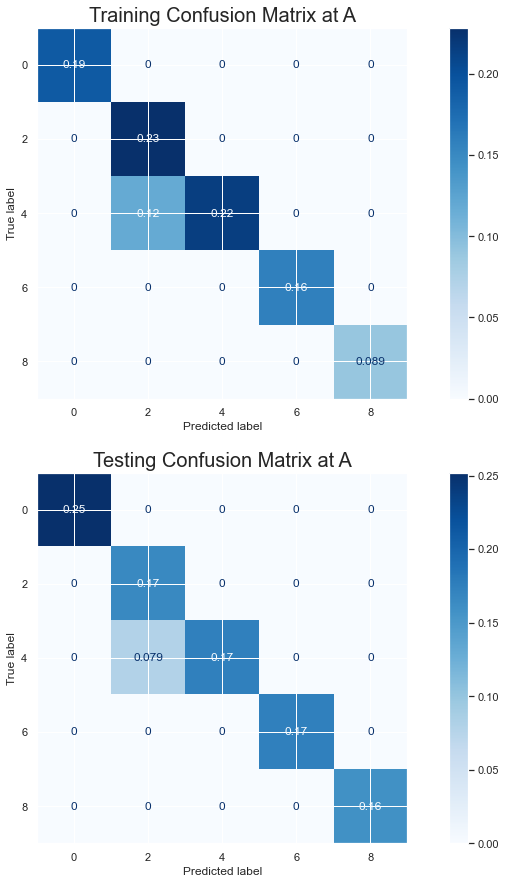

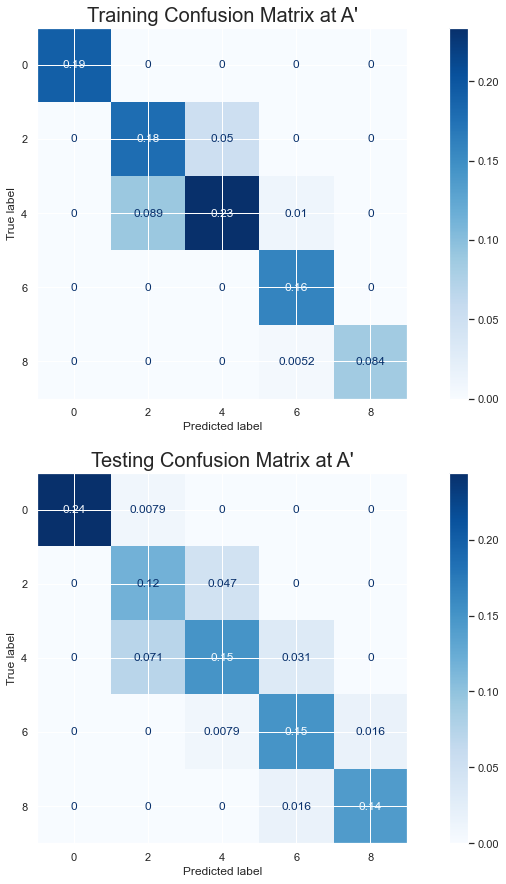

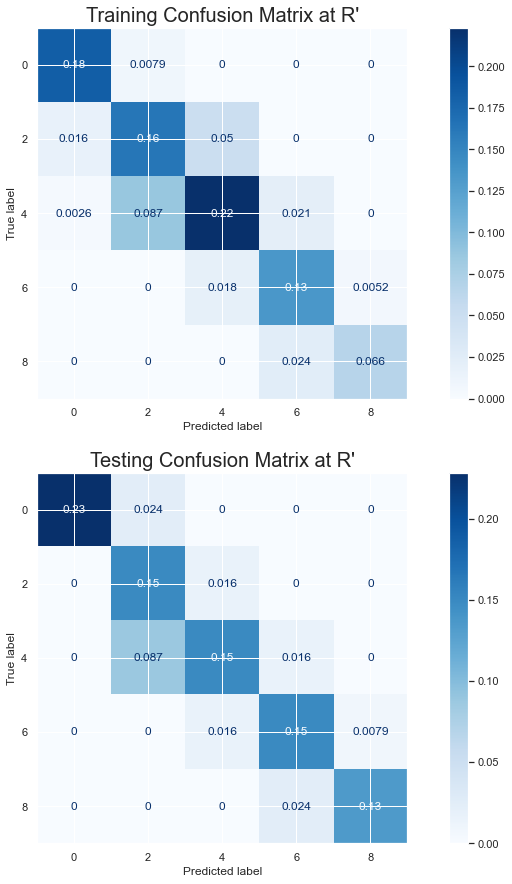

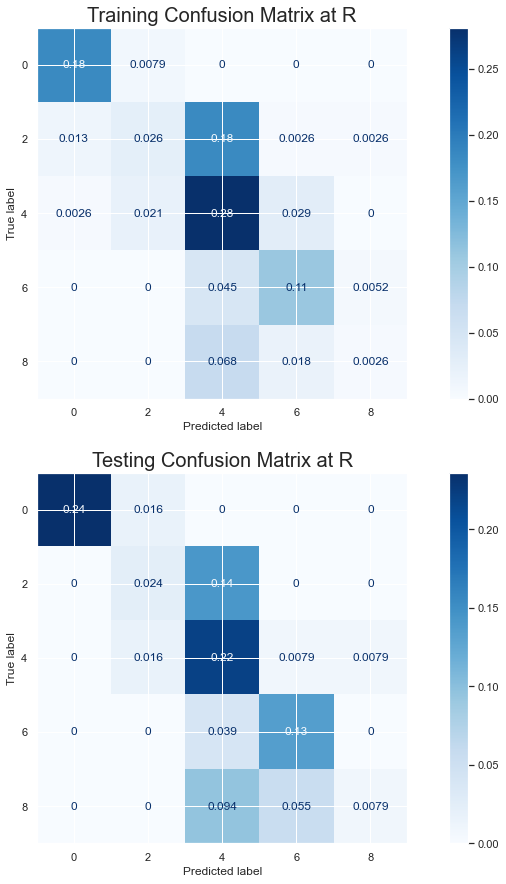

In [622]:
cm_train_by_array = {}
cm_test_by_array  = {}

for array in arrays:
    fig, ax = plt.subplots(2,1,figsize = (15,15))
    # plt.colorbar()
    
    cm_train = plot_confusion_matrix(clf_svm_by_array[array], Xtrain_by_array[array], ytrain, normalize = 'all', display_labels = y.unique(), cmap = "Blues", ax = ax[0])
    cm_test  = plot_confusion_matrix(clf_svm_by_array[array], Xtest_by_array[array],  ytest,  normalize = 'all', display_labels = y.unique(), cmap = 'Blues', ax = ax[1])
    
    cm_train_by_array[array] = cm_train
    cm_test_by_array[array]  = cm_test
    # ax[0].plot(cm_train)
    # ax[1].plot(cm_test)
    
    ax[0].set_title('Training Confusion Matrix at ' + array, fontsize = 20)
    # ax[0].plot('cm_train')
    # ax[0].set_xlabel('Predicted Label')
    # ax[0].set_ylabel('True Label')

    ax[1].set_title('Testing Confusion Matrix at ' + array, fontsize = 20)
    # ax[1].plot('cm_test')
    # ax[1].set_xlabel('Predicted Label')
    # ax[1].set_ylabel('True Label')
    
    fig.savefig(array + '.png', dpi = 250)

In [623]:
colors_index = [0] * 20 
colors_index[0:len(states)] = states
colors = {colors_index[0]:'black', 
          colors_index[1]:'blue', 
          colors_index[2]:'green', 
          colors_index[3]:'purple', 
          colors_index[4]:'red'}

colors

{0: 'black', 2: 'blue', 4: 'green', 6: 'purple', 8: 'red'}

In [624]:
colors.items()

dict_items([(0, 'black'), (2, 'blue'), (4, 'green'), (6, 'purple'), (8, 'red')])

In [625]:
def ml_visual(Xtrain,ytrain,clf_svm,ax):
    X_Set, Y_Set = Xtrain, ytrain;
    X1, X2 = np.meshgrid(np.arange(start = X_Set[:, 0].min() - 1, stop = X_Set[:, 0].max() + 1, step = 0.01),np.arange(start = X_Set[:, 1].min() - 1, stop = X_Set[:, 1].max() + 1, step = 0.01))
    ax.contourf(X1, X2, clf_svm.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha = 0.5, cmap = 'hsv')
    ax.set_xlim(X1.min(), X1.max())
    ax.set_ylim(X2.min(), X2.max())
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('Support Vector Machine Training Set at ' + array, fontsize = 20)
    
    return ax

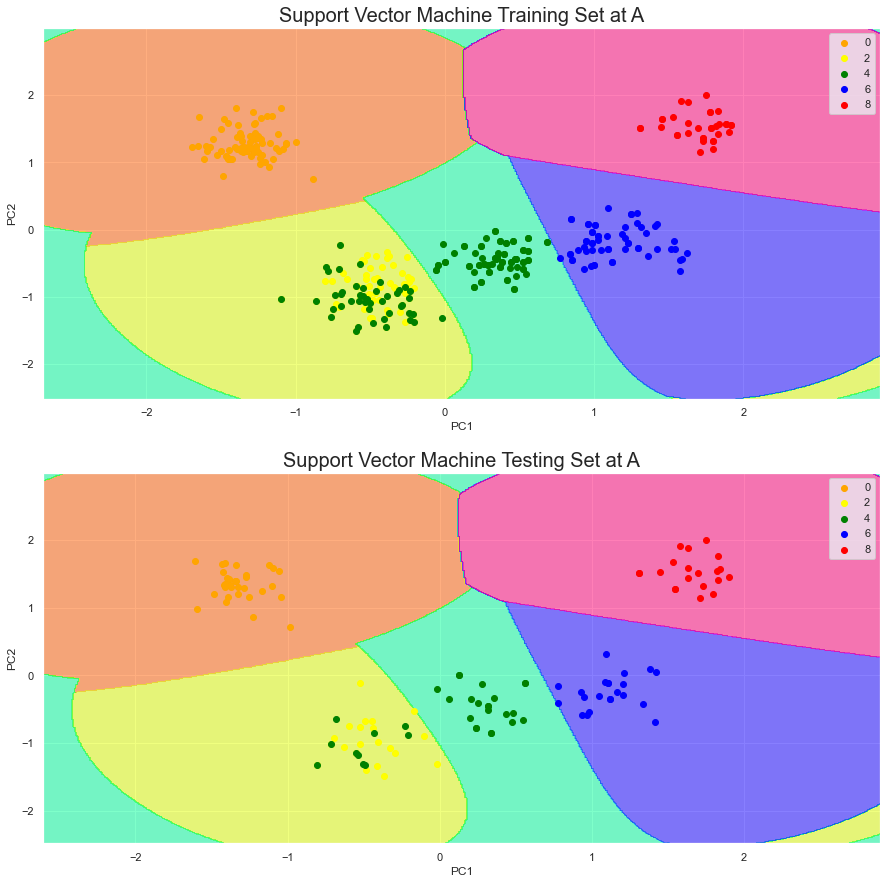

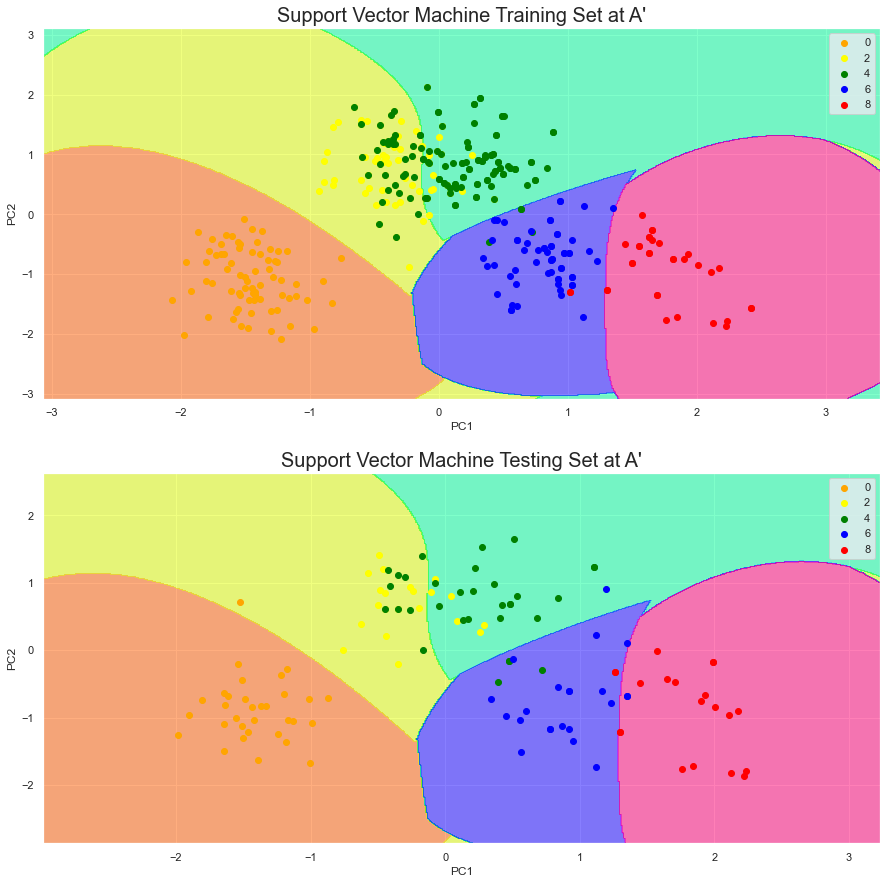

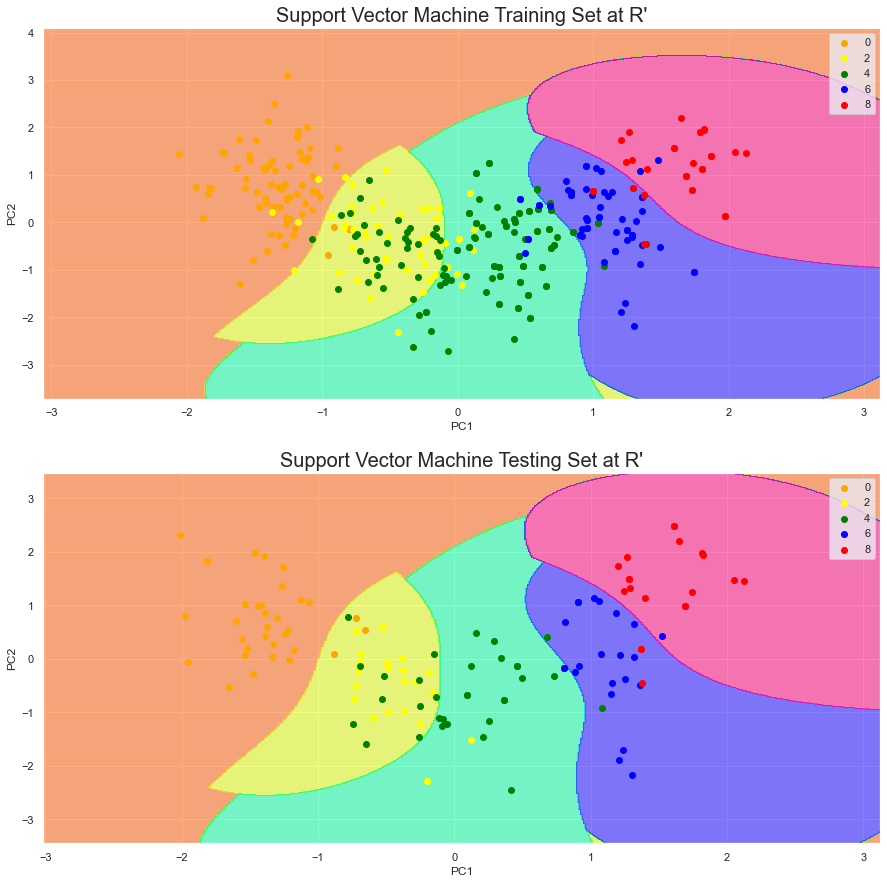

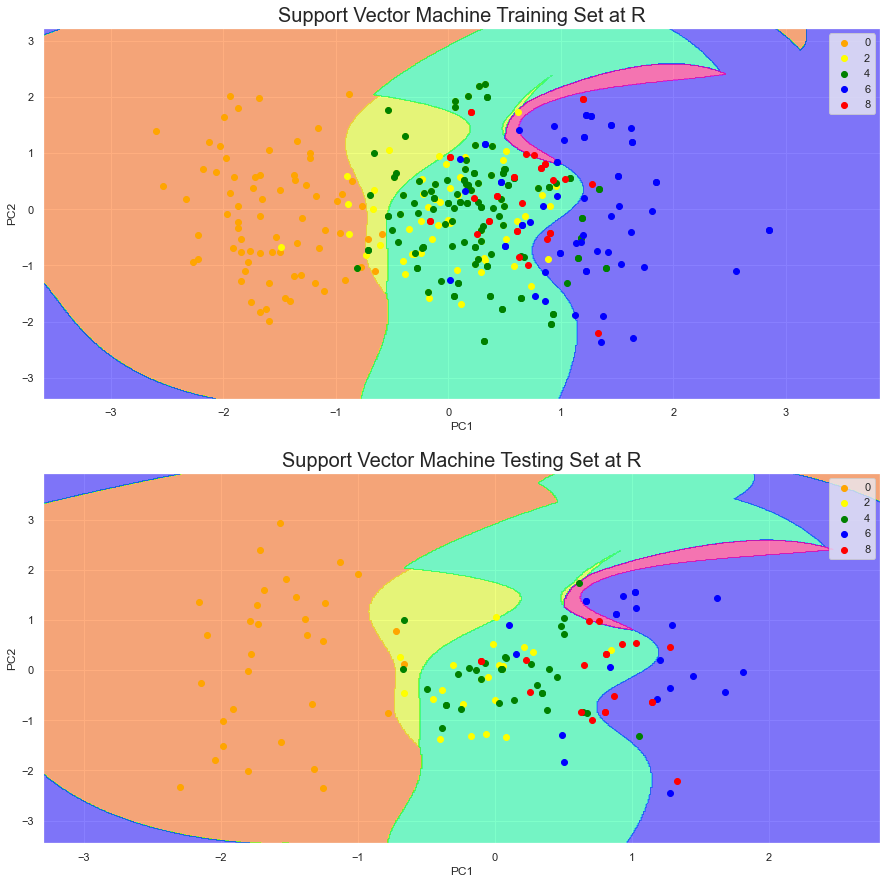

In [626]:
train_visual_by_array = {}
test_visual_by_array  = {}
hyperplanes_visual    = {}

X1s = {}
X2s = {}

from matplotlib.colors import ListedColormap

for array in arrays:

    fig, ax   = plt.subplots(2,1,figsize = (15,15))

    # Visualising the Training set results
    
    X_Set, Y_Set = Xtrain_by_array[array], ytrain
    
    # fill the regions computed by SVM, color-code them in the plot by damaged state 
    X1, X2 = np.meshgrid(np.arange(start = X_Set[:, 0].min() - 1, stop = X_Set[:, 0].max() + 1, step = 0.01),np.arange(start = X_Set[:, 1].min() - 1, stop = X_Set[:, 1].max() + 1, step = 0.01))
    ax[0].contourf(X1, X2, clf_svm_by_array[array].predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha = 0.5, cmap = 'hsv')
    ax[0].set_xlim(X1.min(), X1.max())
    ax[0].set_ylim(X2.min(), X2.max())
    
    ax[0].set_title('Support Vector Machine (Training set)')
    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    ax[0].set_title('Support Vector Machine Training Set at ' + array, fontsize = 20)
    
    # plot the datapoints, also color coded by damaged state
    for i, j in enumerate(np.unique(Y_Set)):
        ax[0].scatter(X_Set[Y_Set == j, 0], X_Set[Y_Set == j, 1], color = ListedColormap(('orange','yellow','green','blue','red'))(i), label = j)
    ax[0].legend()
    # plt.show()

    # Visualising the Test set results
    
    X_Set, Y_Set = Xtest_by_array[array], ytest
    
    # fill the regions computed by SVM, color-code them in the plot by damaged state 
    X1, X2 = np.meshgrid(np.arange(start = X_Set[:, 0].min() - 1, stop = X_Set[:, 0].max() + 1, step = 0.01),np.arange(start = X_Set[:, 1].min() - 1, stop = X_Set[:, 1].max() + 1, step = 0.01))
    ax[1].contourf(X1, X2, clf_svm_by_array[array].predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha = 0.5, cmap = 'hsv')
    ax[1].set_xlim(X1.min(), X1.max())
    ax[1].set_ylim(X2.min(), X2.max())
    
    # plot the datapoints, also color coded by damaged state
    for i, j in enumerate(np.unique(Y_Set)):
        ax[1].scatter(X_Set[Y_Set == j, 0], X_Set[Y_Set == j, 1], color = ListedColormap(('orange','yellow','green','blue','red'))(i), label = j)
    ax[1].set_title('Support Vector Machine (Testing set)')
    ax[1].set_xlabel('PC1')
    ax[1].set_ylabel('PC2')
    ax[1].legend()
    # plt.show()
    
    ax[1].set_title('Support Vector Machine Testing Set at ' + array, fontsize = 20)
    
    hyperplanes_visual[array] = ax

    
    fig.savefig('Machine Learning Visual at ' + array + '.png', dpi = 250)

In [627]:
clf_svm_by_array

{'A': SVC(C=0.19543435157676795, gamma='auto', random_state=42),
 "A'": SVC(C=1.0098038732144923, gamma='auto', random_state=42),
 "R'": SVC(C=1.2322246613684977, gamma='auto', random_state=42),
 'R': SVC(C=8.165675299418176, gamma='auto', random_state=42)}

In [628]:
pickle.dump(hyperplanes_visual,open('Experimental Visual Hyperplanes','ab'))
pickle.dump(train_visual_by_array, open('Experimental SVM Train Results','ab'))

In [629]:
trained = pickle.load(open('Experimental SVM Train Results','rb'))
trained

{}

In [630]:
hyperplanes_visual['A\''].figure

AttributeError: 'numpy.ndarray' object has no attribute 'figure'

In [ ]:
pickle.dump(hyperplanes_visual['A\''],open('Experimental Visual Hyperplanes A\'','ab'))

In [ ]:
visA = pickle.load(open('Experimental Visual Hyperplanes A\'','rb'))
visA

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
# spans two rows:
ax3 = fig.add_subplot(gs[:, 1])
ax3  =train_visual_by_array['A\'']

In [ ]:
ax3 = train_visual_by_array['A\'']
fig